# 0.0 IMPORTS

In [54]:
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
import matplotlib           as mpl

from IPython.display       import Image
from phik                  import phik_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from scipy                 import stats as ss


## 0.1 Helper Functions

In [50]:
# CRAMER V

def cramer_v( x, y ):

    cm = pd.crosstab(x, y).values

    n = cm.sum()

    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [2]:
# Dark Theme charts
plt.style.use('dark_background')
mpl.rcParams['figure.facecolor'] = '#282828'
mpl.rcParams['axes.facecolor'] = '#282828'
mpl.rcParams['axes.edgecolor'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

# Charts Size Config
plt.rcParams['figure.figsize'] = [25, 12]
mpl.rcParams['font.size'] = 14

## 0.2 Loading Data

In [3]:
# Loading raw data
df_raw = pd.read_csv('../datasets/train.csv')
df_raw.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


| Coluna               | Descrição                                                                                     |
|----------------------|-----------------------------------------------------------------------------------------------|
| id                   | Unique ID for the customer                                                                   |
| Gender               | Gender of the customer                                                                       |
| Age                  | Age of the customer                                                                          |
| Driving_License      | 0: Customer does not have DL, 1: Customer already has DL                                      |
| Region_Code          | Unique code for the region of the customer                                                    |
| Previously_Insured   | 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance         |
| Vehicle_Age          | Age of the Vehicle                                                                           |
| Vehicle_Damage       | 1: Customer got his/her vehicle damaged in the past. 0: Customer didn't get vehicle damaged  |
| Annual_Premium       | The amount customer needs to pay as premium in the year                                       |
| Policy_Sales_Channel | Anonymized Code for the channel of outreaching to the customer                                |
| Vintage              | Number of Days, Customer has been associated with the company                                 |
| Response             | 1: Customer is interested, 0: Customer is not interested                                     |


# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
df1 = df1.rename(columns=str.lower)

## 1.2 Data Dimension

In [6]:
# Data Dimension
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [8]:
df1['policy_sales_channel'].unique()

array([ 26., 152., 160., 124.,  14.,  13.,  30., 156., 163., 157., 122.,
        19.,  22.,  15., 154.,  16.,  52., 155.,  11., 151., 125.,  25.,
        61.,   1.,  86.,  31., 150.,  23.,  60.,  21., 121.,   3., 139.,
        12.,  29.,  55.,   7.,  47., 127., 153.,  78., 158.,  89.,  32.,
         8.,  10., 120.,  65.,   4.,  42.,  83., 136.,  24.,  18.,  56.,
        48., 106.,  54.,  93., 116.,  91.,  45.,   9., 145., 147.,  44.,
       109.,  37., 140., 107., 128., 131., 114., 118., 159., 119., 105.,
       135.,  62., 138., 129.,  88.,  92., 111., 113.,  73.,  36.,  28.,
        35.,  59.,  53., 148., 133., 108.,  64.,  39.,  94., 132.,  46.,
        81., 103.,  90.,  51.,  27., 146.,  63.,  96.,  40.,  66., 100.,
        95., 123.,  98.,  75.,  69., 130., 134.,  49.,  97.,  38.,  17.,
       110.,  80.,  71., 117.,  58.,  20.,  76., 104.,  87.,  84., 137.,
       126.,  68.,  67., 101., 115.,  57.,  82.,  79., 112.,  99.,  70.,
         2.,  34.,  33.,  74., 102., 149.,  43.,   

## 1.4 Check NaN

In [9]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## ~~1.5 Fillout NaN~~

## 1.6 Change Types

In [10]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code               int32
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel      int32
vintage                   int64
response                  int64
dtype: object

## 1.7 Descriptive Statical

In [11]:
# Separete vars 

num_attributes = df1.select_dtypes(include=['int','float'])
cat_attributes = df1.select_dtypes(exclude=['int','float'])

### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency (ct) - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min) ).T
d3 = pd.DataFrame(num_attributes.apply(max) ).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Concatenate - save in "m" metrics

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


C:\Users\andre\AppData\Local\Temp\ipykernel_1908\2681509026.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['response'])


<Axes: xlabel='response', ylabel='Density'>

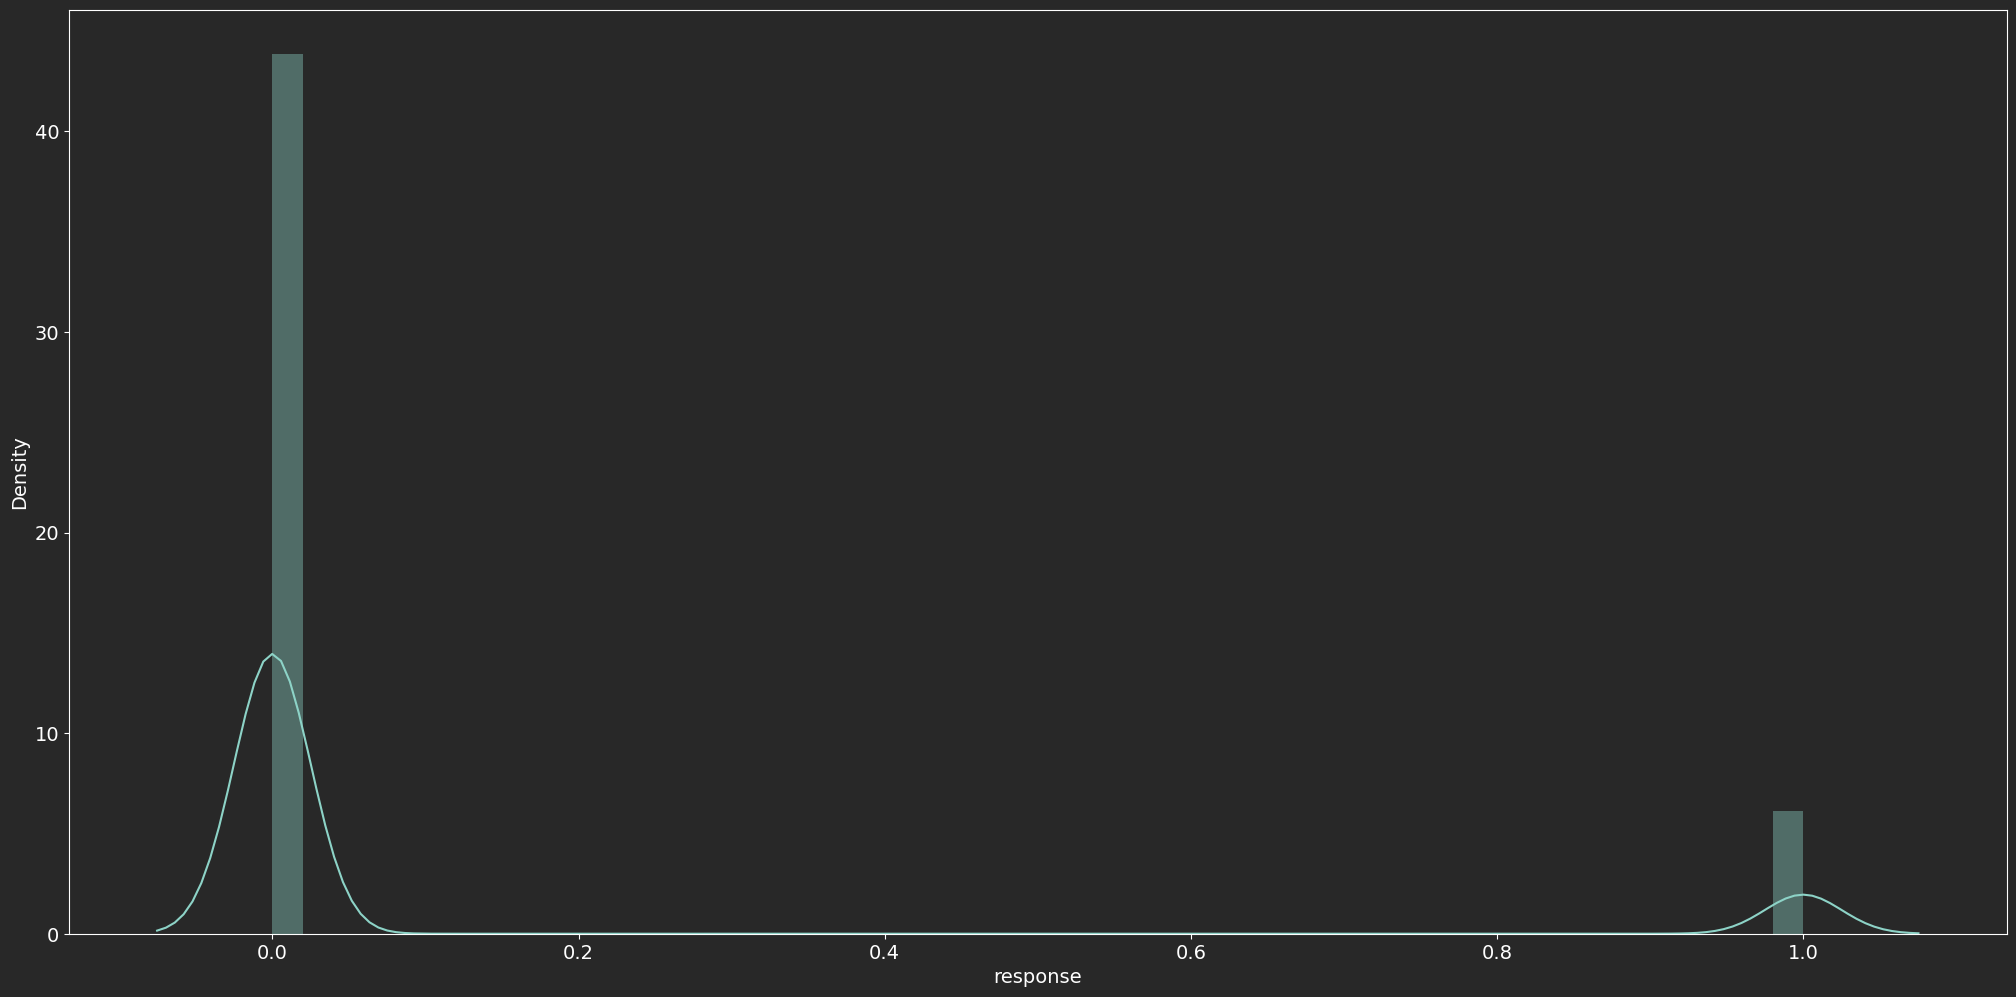

In [13]:
sns.distplot(df1['response'])

### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

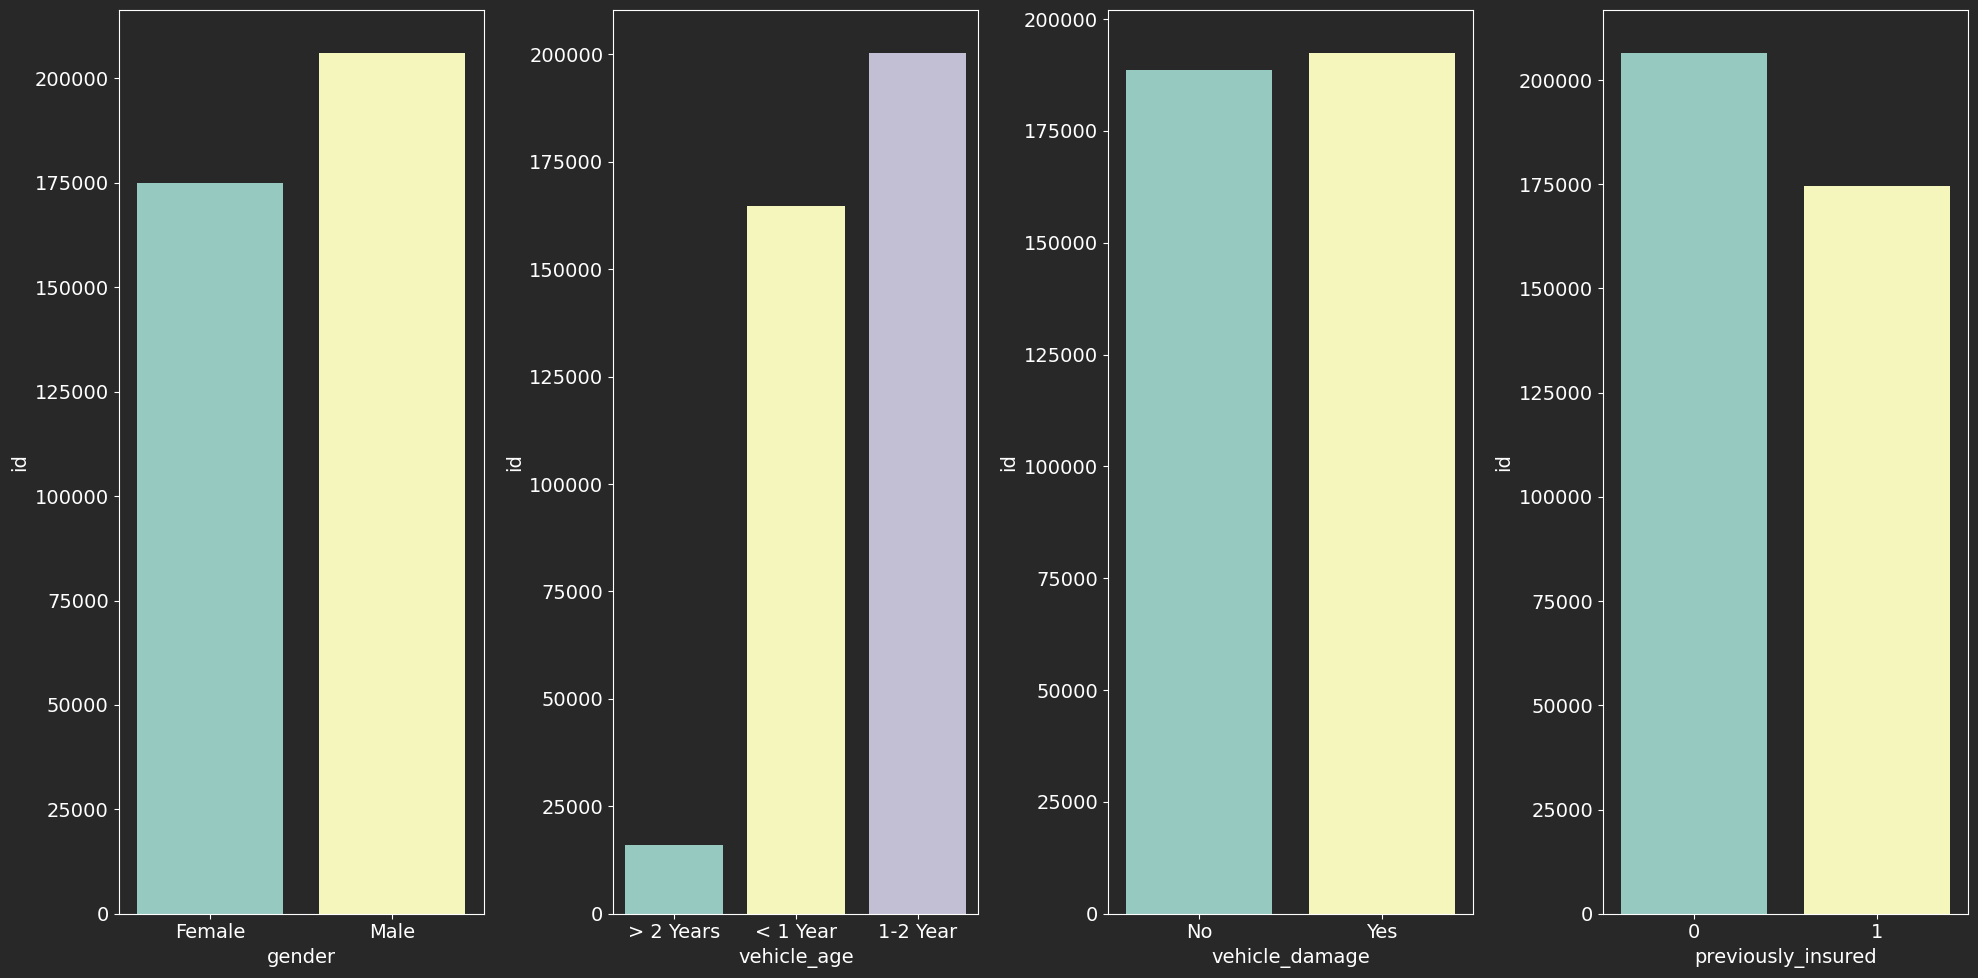

In [15]:
# Charts about categorical attributes 

aux1 = df1.loc[:, ['gender', 'id']].groupby('gender').count().sort_values('id', ascending=True).reset_index()
aux1

aux2 = df1.loc[:, ['vehicle_age', 'id']].groupby('vehicle_age').count().sort_values('id', ascending=True).reset_index()
aux2

aux3 = df1.loc[:, ['vehicle_damage', 'id']].groupby('vehicle_damage').count().sort_values('id', ascending=True).reset_index()
aux3

aux4 = df1.loc[:, ['previously_insured', 'id']].groupby('previously_insured').count().sort_values('id', ascending=True).reset_index()
aux4 # 1: Customer already has Vehicle Insurance, 0: Customer doesn't have Vehicle Insurance


# plt.subplot(1,4,1)
# sns.barplot(data=aux1, x='gender', y='id')
# plt.subplot(1,4,2)
# sns.barplot(data=aux2, x='vehicle_age', y='id')
# plt.subplot(1,4,3)
# sns.barplot(data=aux3, x='vehicle_damage', y='id')
# plt.subplot(1,4,4)
# sns.barplot(data=aux4, x='previously_insured', y='id')


fig, axs = plt.subplots(1, 4, figsize=(20, 10))

sns.barplot(data=aux1, x='gender', y='id', ax=axs[0])
sns.barplot(data=aux2, x='vehicle_age', y='id', ax=axs[1])
sns.barplot(data=aux3, x='vehicle_damage', y='id', ax=axs[2])
sns.barplot(data=aux4, x='previously_insured', y='id', ax=axs[3])

plt.tight_layout()

# 2.0 Feature Engineering

## 2.1 MindMap Hypotheses

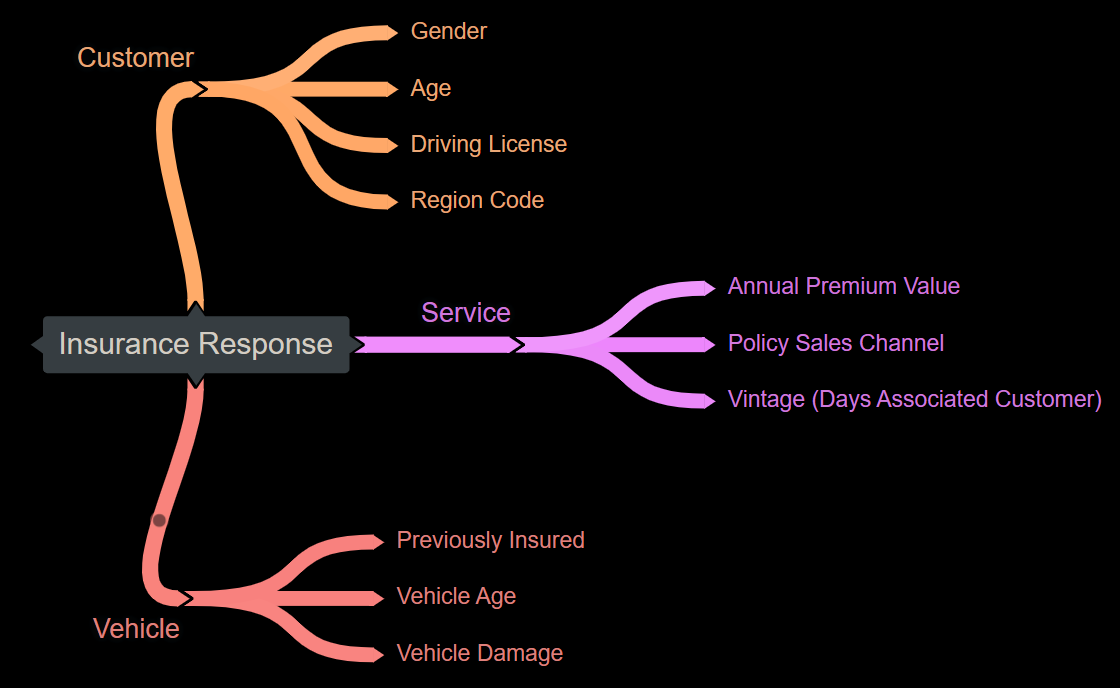

In [16]:
Image('../images/mindmap_insurance.PNG')

## 2.2 Hypoteses Creation

In [17]:
df2 = df1.copy()

### 2.2.1 Hypoteses Customer

**1.** Clientes com maior idade possuem mais interesse no seguro.

**2.** Clientes masculinos possuem mais interesse no seguro.

**3.** Clientes com licença para dirigir possuem mais interesse no seguro.

**4.** Clientes da região 8 possuem mais interesse no seguro.

### 2.2.2 Hypoteses Vehicle

**1.** Clientes com o veículo já assegurado não possuem interesse no seguro.

**2.** Veículos mais novos possuem mais interesse no seguro.

**3.** Veículos já danificados possuem menos interesse no seguro.

### 2.2.3 Hypoteses Service

**1.** Valores menores de seguro interessam mais os clientes.

**2.** Os canais de vendas 122 e 160 possuem mais retorno positivo para o seguro.

**3.** Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.

## 2.3 Final List of Hypoteses

**1.** Clientes com maior idade possuem mais interesse no seguro.

**2.** Clientes masculinos possuem mais interesse no seguro.

**3.** Clientes com licença para dirigir possuem mais interesse no seguro.

**4.** Clientes da região 8 possuem mais interesse no seguro.

**5.** Clientes com o veículo já assegurado não possuem interesse no seguro.

**6.** Veículos mais novos possuem mais interesse no seguro.

**7.** Veículos já danificados possuem menos interesse no seguro.

**8.** Valores menores de seguro interessam mais os clientes.

**9.** Os canais de vendas 122 e 160 possuem mais retorno positivo para o seguro.

**10.** Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.

## ~~2.4 Feature Engineering~~

# 3.0 Variable Filtering

In [18]:
df3 = df2.copy()

## ~~3.1 Rows Filtering~~

## ~~3.2 Columns Select~~

# 4.0 Exploratory Data Analysis

In [19]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\andre\AppData\Local\Temp\ipykernel_1908\3518556581.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['response']);


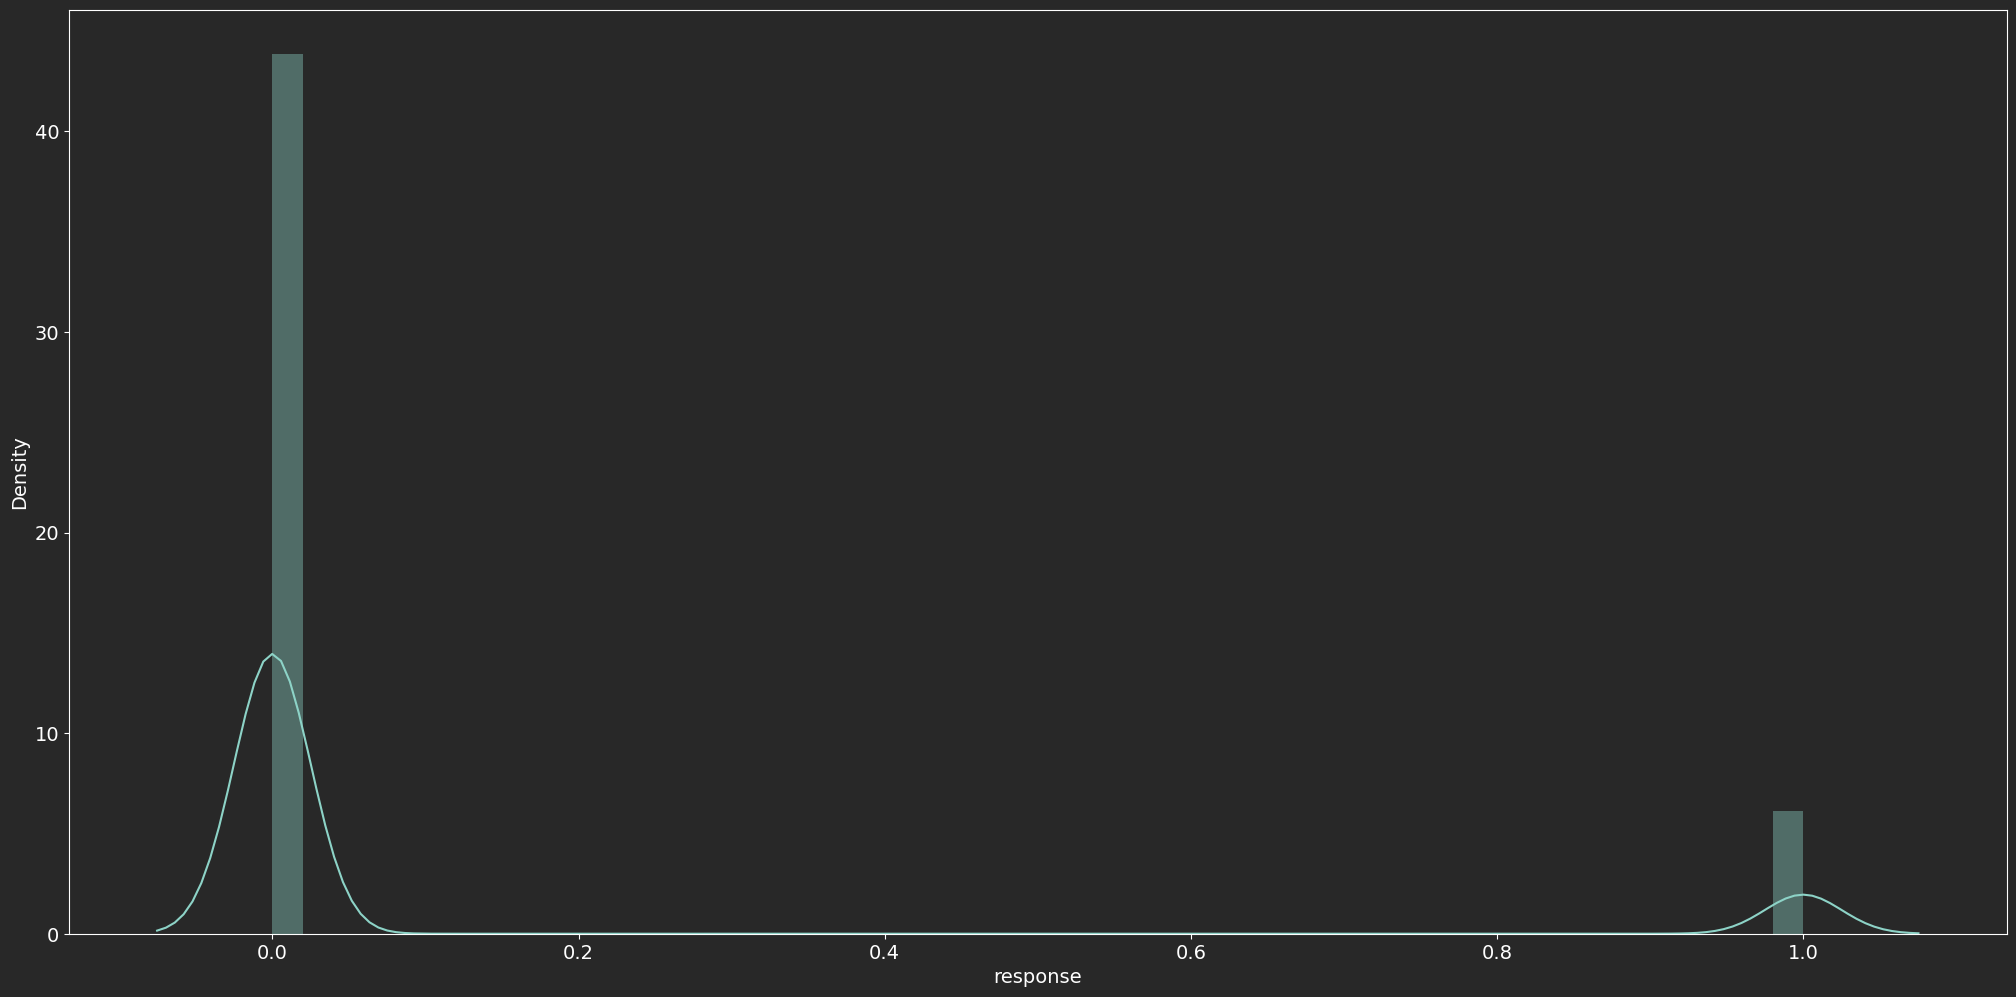

In [20]:
sns.distplot(df4['response']);

### 4.1.2 Numerical Variable

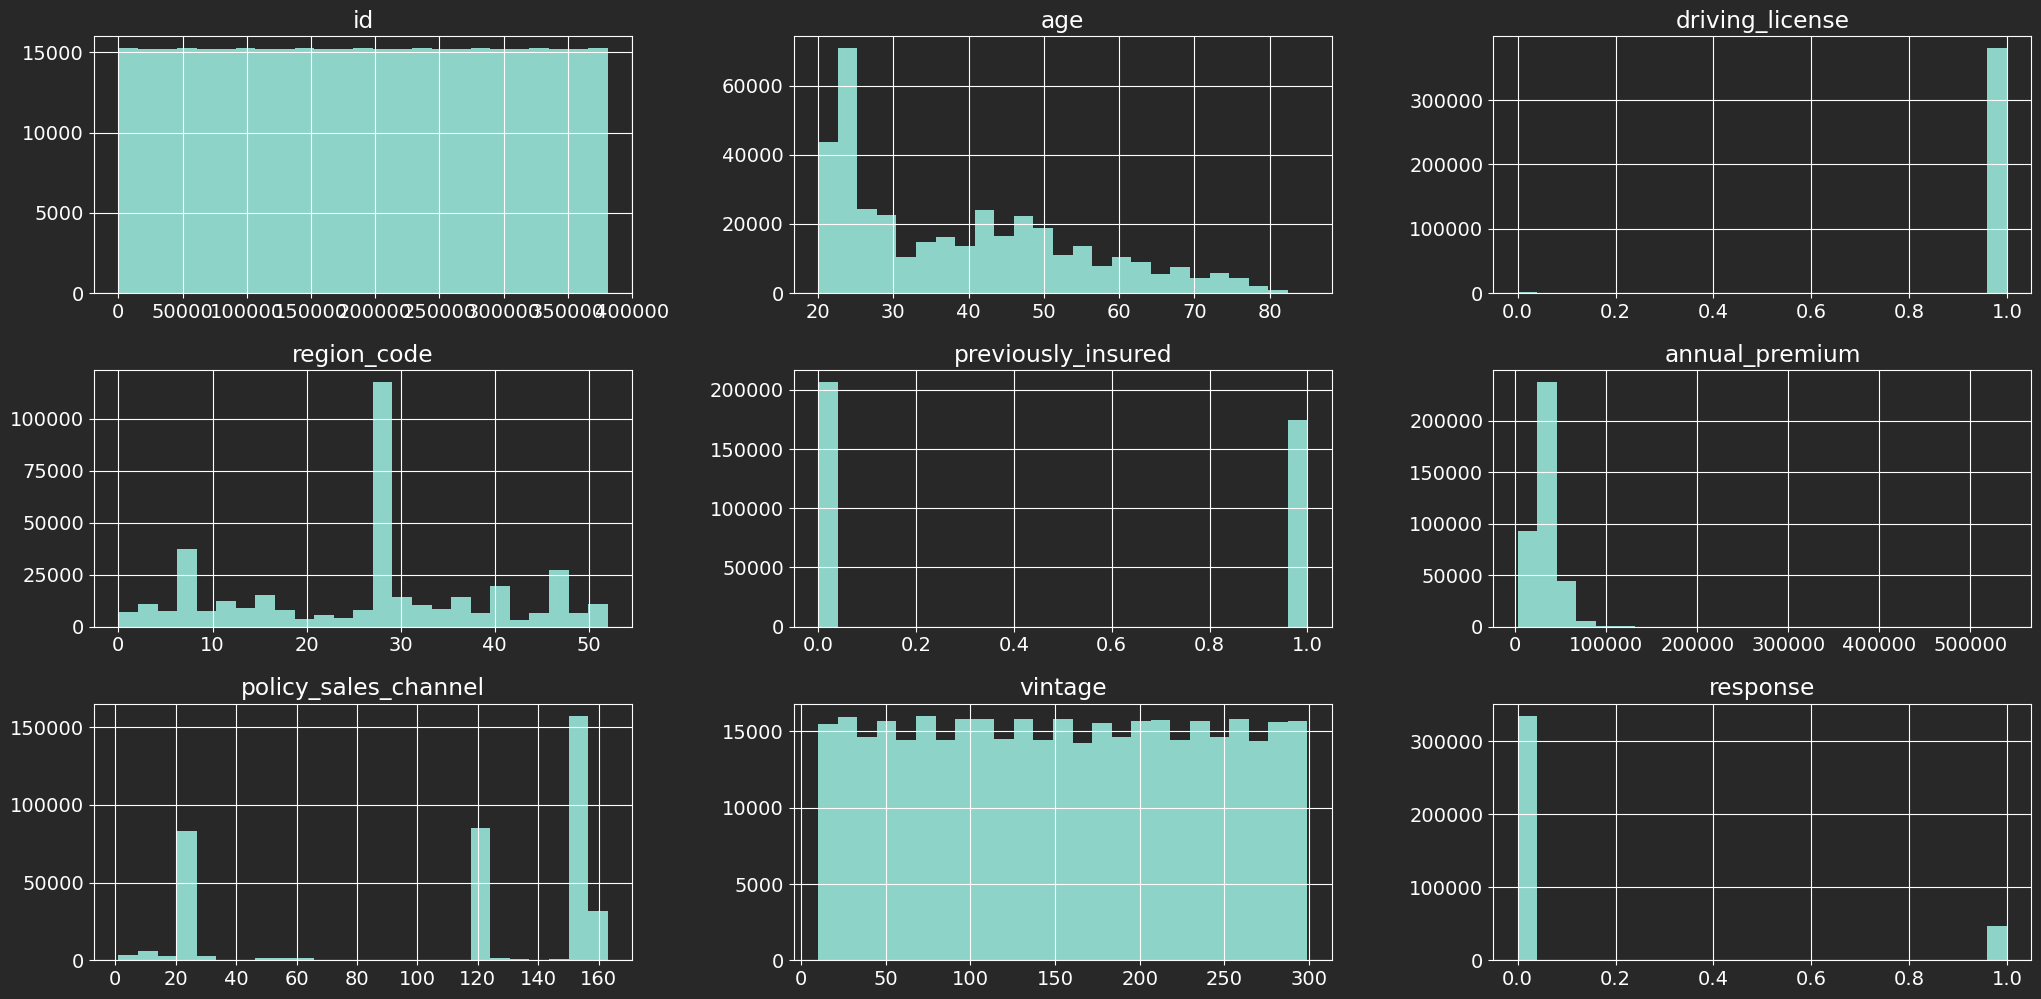

In [21]:
num_attributes.hist(bins=25);

# O eixo horizontal representa os intervalos dos valores e o eixo vertical representa a contagem de ocorrências.

### 4.1.3 Categorical Variable

In [22]:
df4['gender'].drop_duplicates()
df4['vehicle_age'].drop_duplicates()
# df4['vehicle_damage'].drop_duplicates()

0    > 2 Years
1     1-2 Year
3     < 1 Year
Name: vehicle_age, dtype: object

C:\Users\andre\AppData\Local\Temp\ipykernel_1908\680826365.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)
C:\Users\andre\AppData\Local\Temp\ipykernel_1908\680826365.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 2)


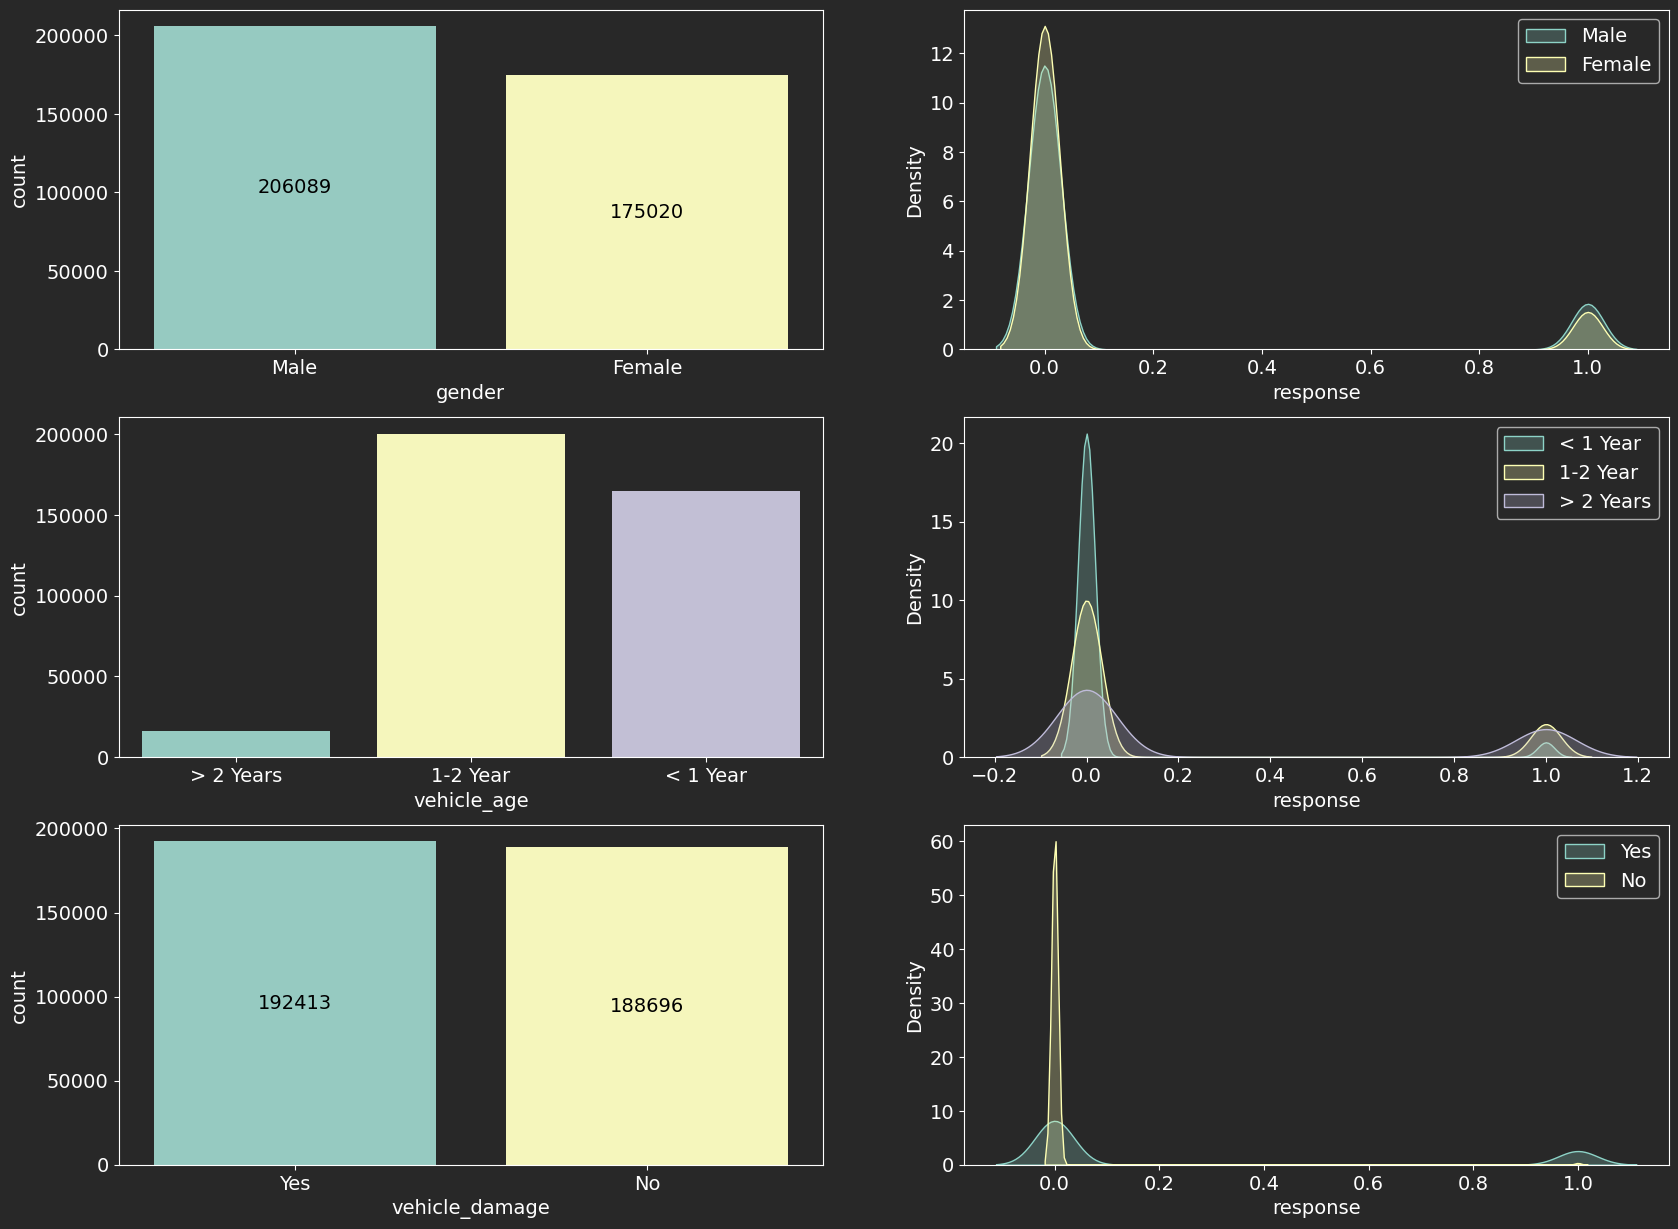

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(20, 15))

# Gender var
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x = df4['gender'])
ax1.bar_label(ax1.containers[0], label_type='center', fontsize=14, color='black')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['gender'] == 'Male']['response'], label = 'Male', fill = True)
sns.kdeplot(df4[df4['gender'] == 'Female']['response'], label = 'Female', fill = True)
plt.legend()


# Vehicle_age var
plt.subplot(3, 2, 3)
sns.countplot(x = df4['vehicle_age'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['vehicle_age'] == '< 1 Year']['response'], label = '< 1 Year', fill = True)
sns.kdeplot(df4[df4['vehicle_age'] == '1-2 Year']['response'], label = '1-2 Year', fill = True)
sns.kdeplot(df4[df4['vehicle_age'] == '> 2 Years']['response'], label = '> 2 Years', fill = True)
plt.legend()


# Vehicle_damage var 
plt.subplot(3, 2, 5)
ax2 = sns.countplot(x = df4['vehicle_damage'])
ax2.bar_label(ax2.containers[0], label_type='center', fontsize=14, color='black')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['vehicle_damage'] == 'Yes']['response'], label = 'Yes', fill = True)
sns.kdeplot(df4[df4['vehicle_damage'] == 'No']['response'], label = 'No', fill = True)
plt.legend()


## 4.2 Bivariate Analysis

### **H1.** Clientes com maior idade possuem mais interesse no seguro.
**False** - Clientes entre 36 a 45 anos de idade possuem mais interesse no seguro.

<Axes: >

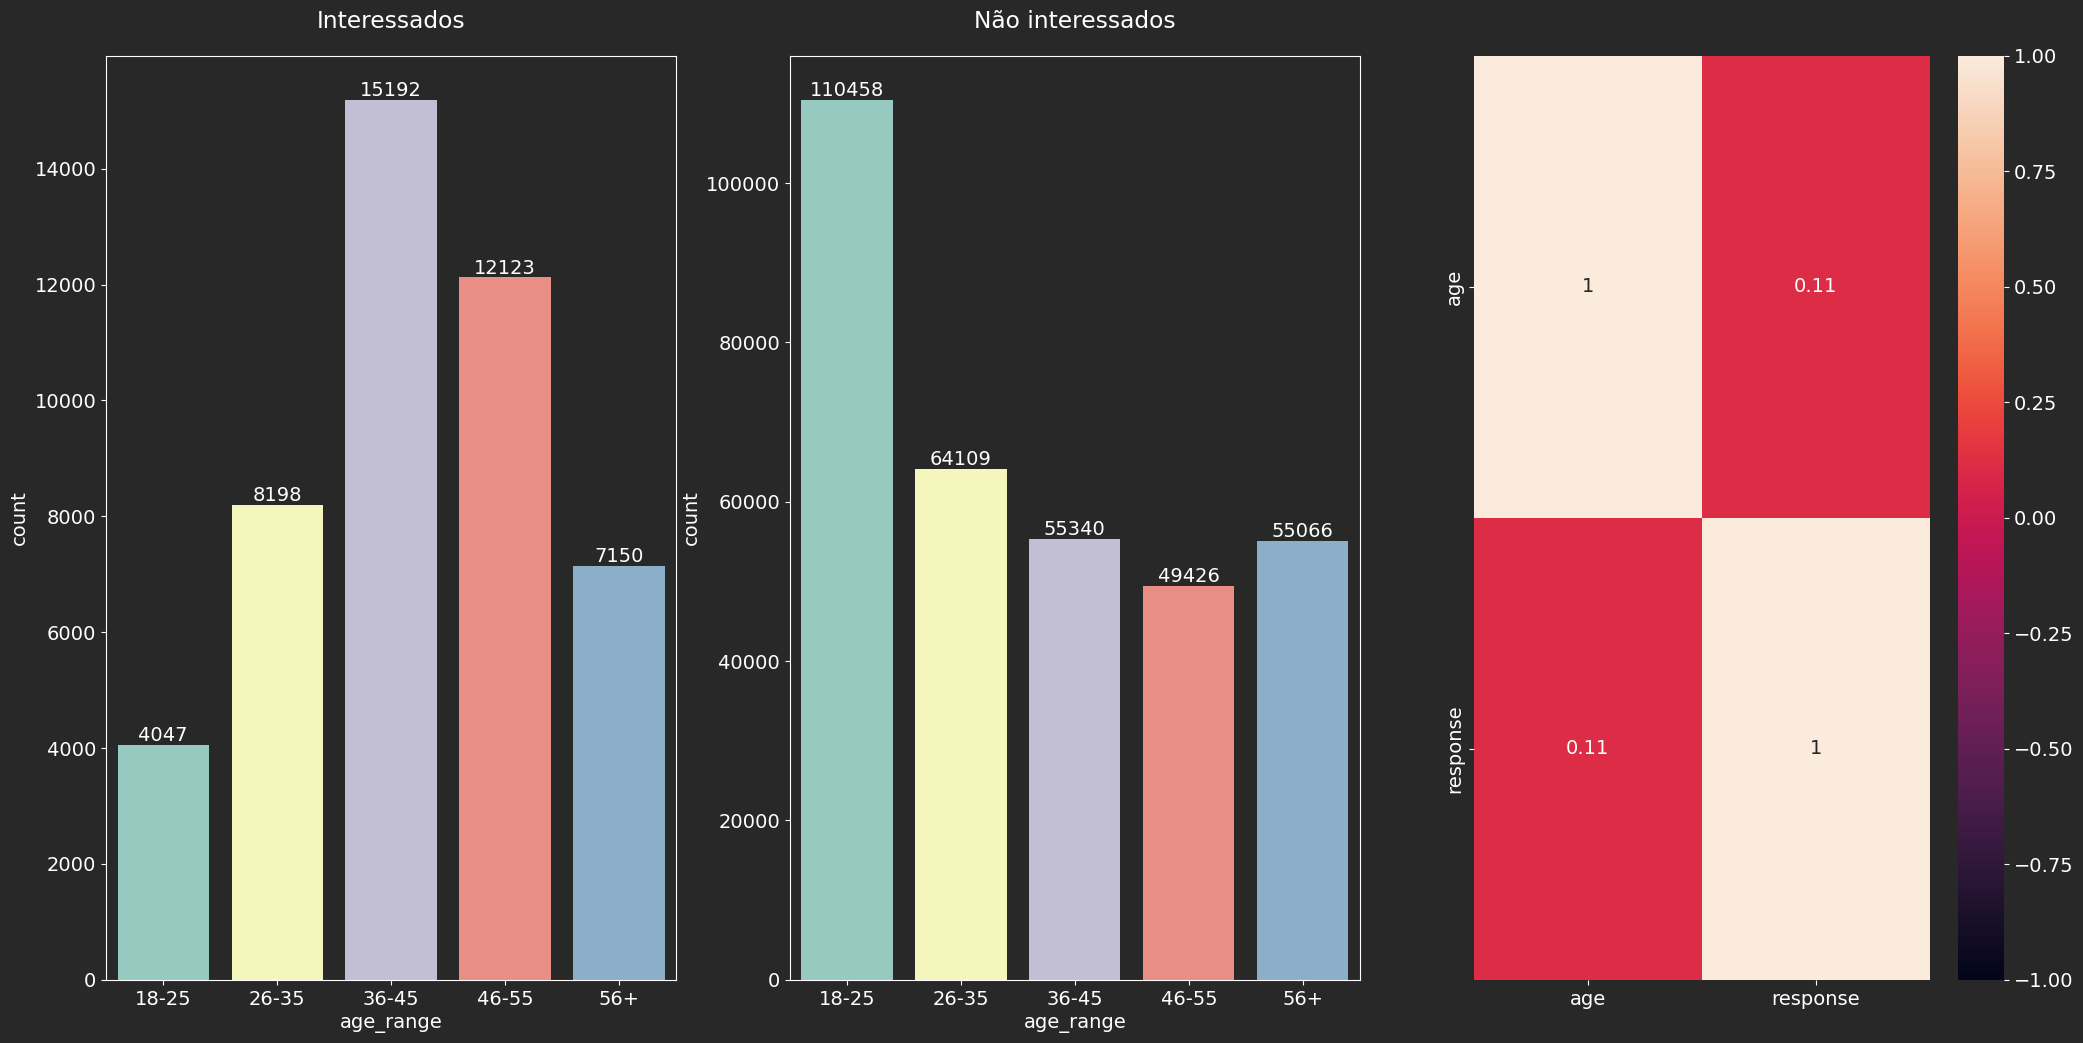

In [40]:
# Creating age ranges
aux_age = df4.copy()
range = [18, 26, 36, 46, 56, 200]
labels = ['18-25', '26-35', '36-45', '46-55', '56+']
aux_age['age_range'] = pd.cut(aux_age['age'], bins=range, labels=labels, right=False)


# Charts
plt.subplot(1, 3, 1)
aux_age1 = aux_age[aux_age['response'] == 1]
ax1 = sns.countplot(data=aux_age1, x=aux_age1['age_range'])
ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=14, color='white')
plt.title('Interessados', pad=20)

plt.subplot(1, 3, 2)
aux_age2 = aux_age[aux_age['response'] == 0]
ax2 = sns.countplot(data=aux_age2, x=aux_age2['age_range'])
ax2.bar_label(ax2.containers[0], label_type='edge', fontsize=14, color='white')
plt.title('Não interessados', pad=20)


# Correlation
plt.subplot(1, 3, 3)
age_corr = aux_age[['age', 'response']]
sns.heatmap(age_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.11: Weak positive correlation.

### **H2.** Clientes masculinos possuem mais interesse no seguro.
**True** - Clientes masculinos possuem MAIS interesse no seguro.

<Axes: >

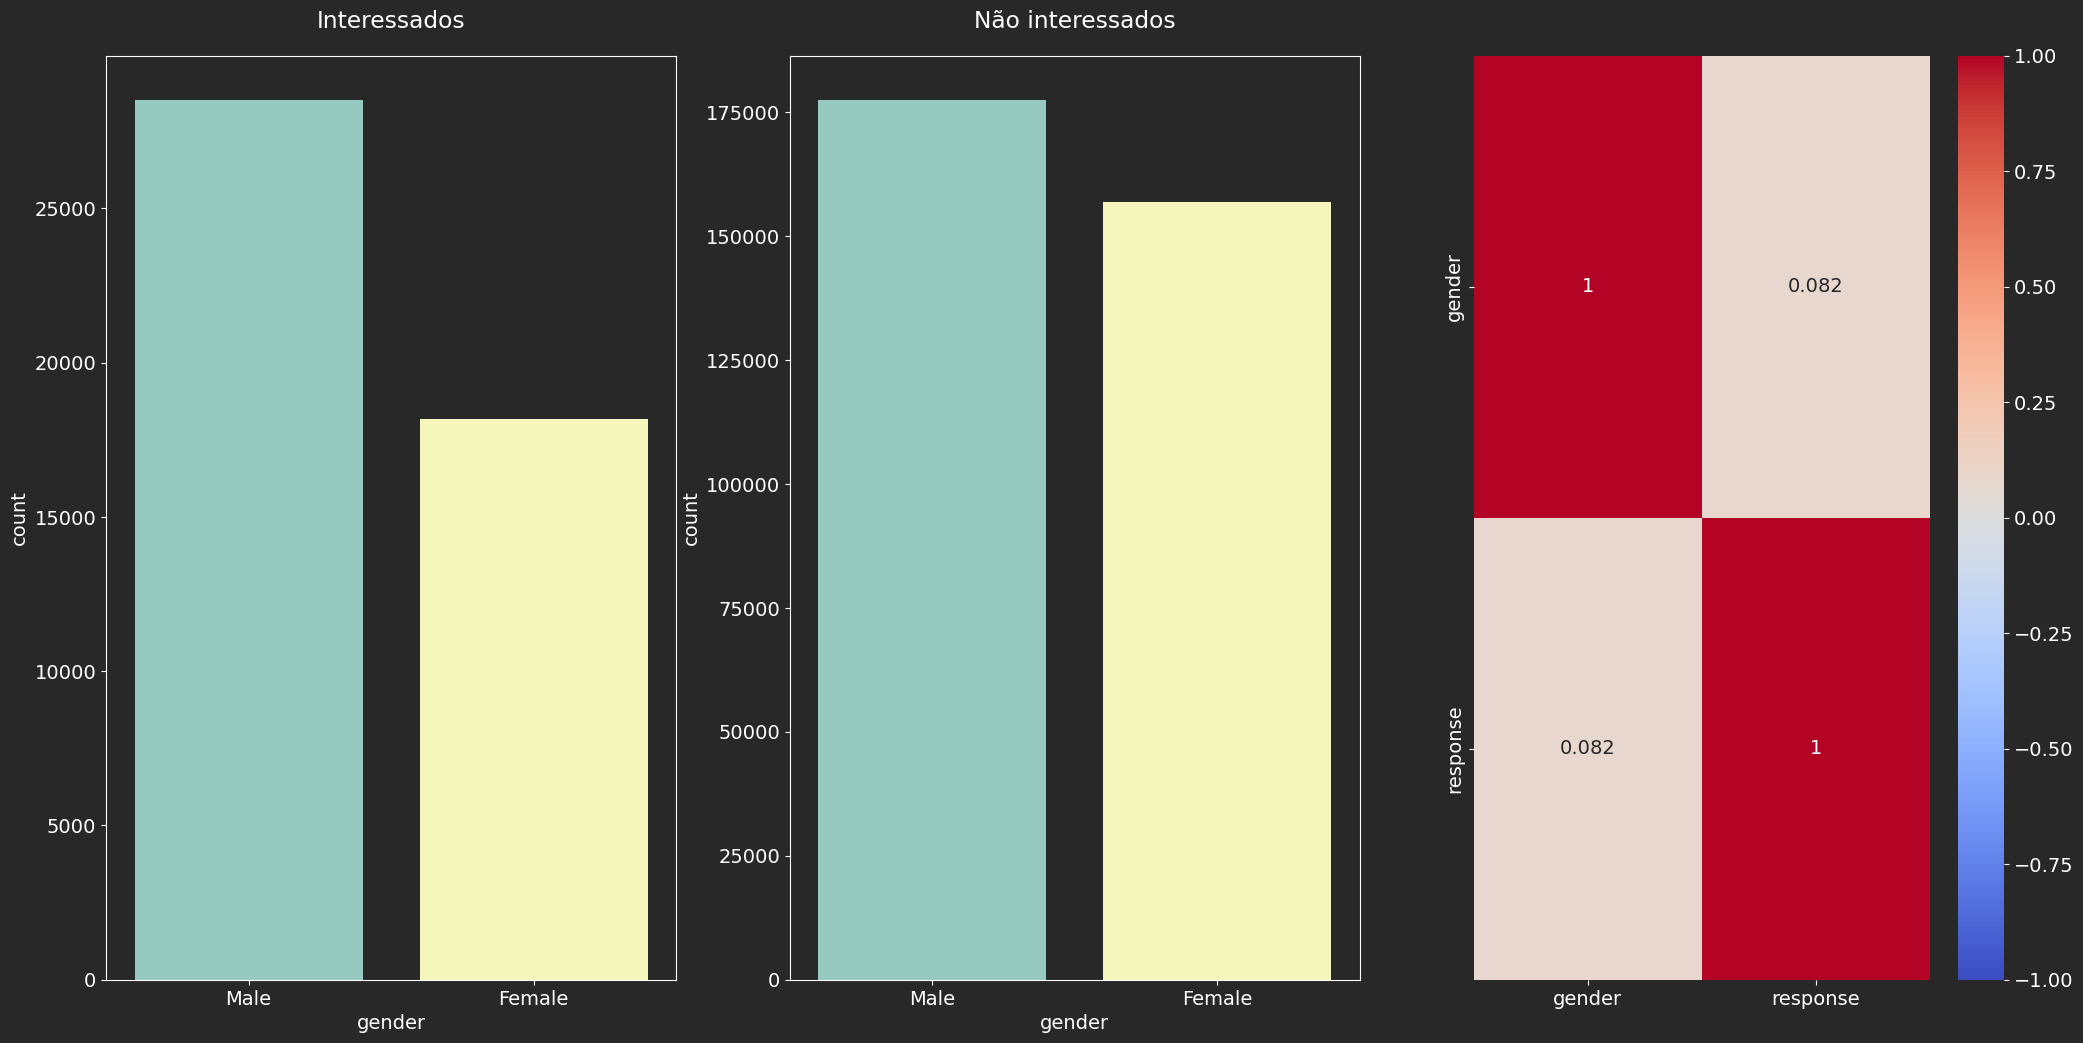

In [25]:
aux_male_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_male_1, x=aux_male_1['gender'])
plt.title('Interessados', pad=20)


aux_male_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_male_0, x=aux_male_0['gender'])
plt.title('Não interessados', pad=20)


gender_corr = df4[['gender', 'response']].copy()
gender_corr['gender'] = gender_corr['gender'].apply(lambda x: 1 if x == 'Male' else 0)
plt.subplot(1, 3, 3)
phi_matrix = phik_matrix(gender_corr, interval_cols=['response'])
sns.heatmap(data = phi_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Correlation found 0.082: Weak positive correlation.

### **H3.** Clientes com licença para dirigir possuem mais interesse no seguro.
**True** - Clientes com licença para dirigir possuem mais interesse no seguro.

<Axes: >

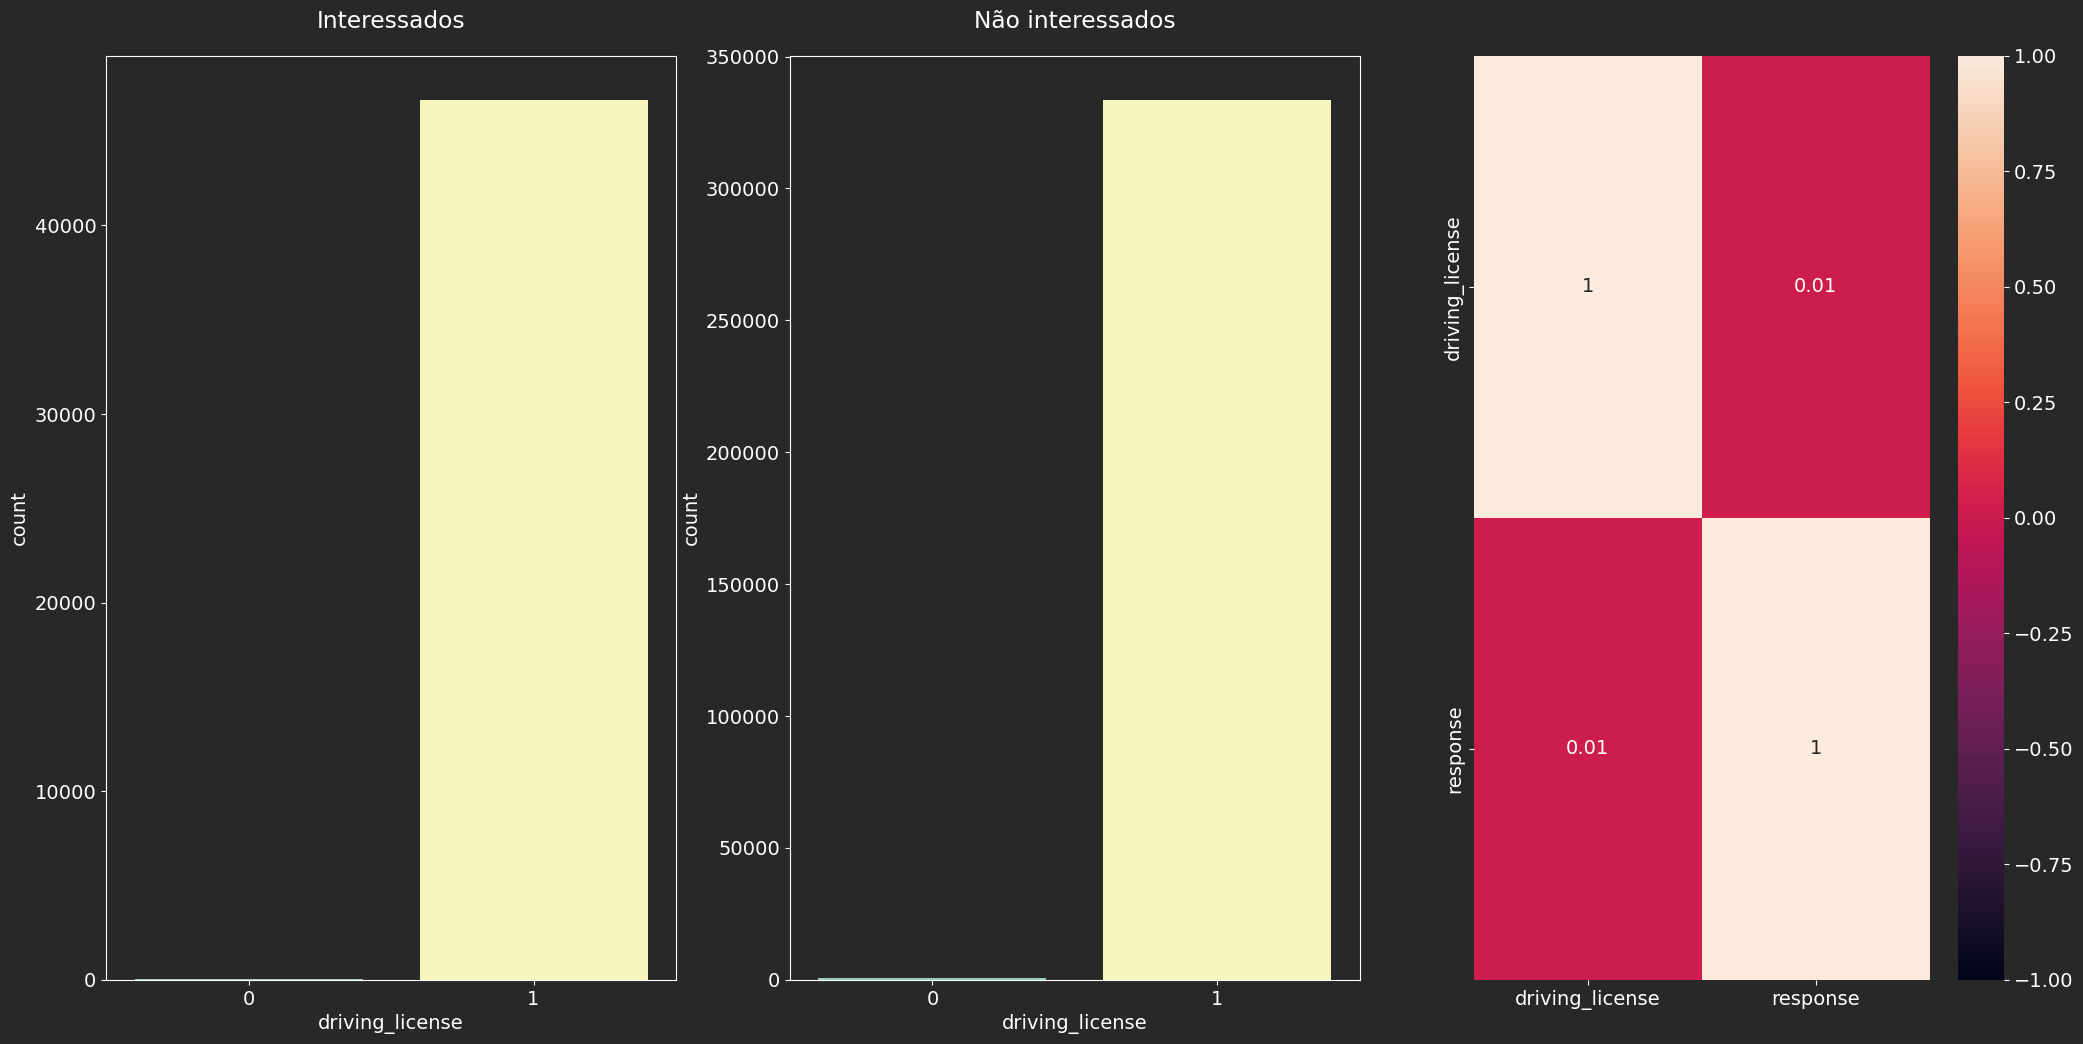

In [41]:
aux_drive_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_drive_1, x=aux_drive_1['driving_license'])
plt.title('Interessados', pad=20)


aux_drive_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_drive_0, x=aux_drive_0['driving_license'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
driving_license_corr = df4[['driving_license', 'response']].copy()
sns.heatmap(driving_license_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.01: Weak positive correlation.

### **H4.** Clientes da região 8 possuem mais interesse no seguro.
**False** - Clientes da região 28 possuem mais interesse no seguro.

<Axes: >

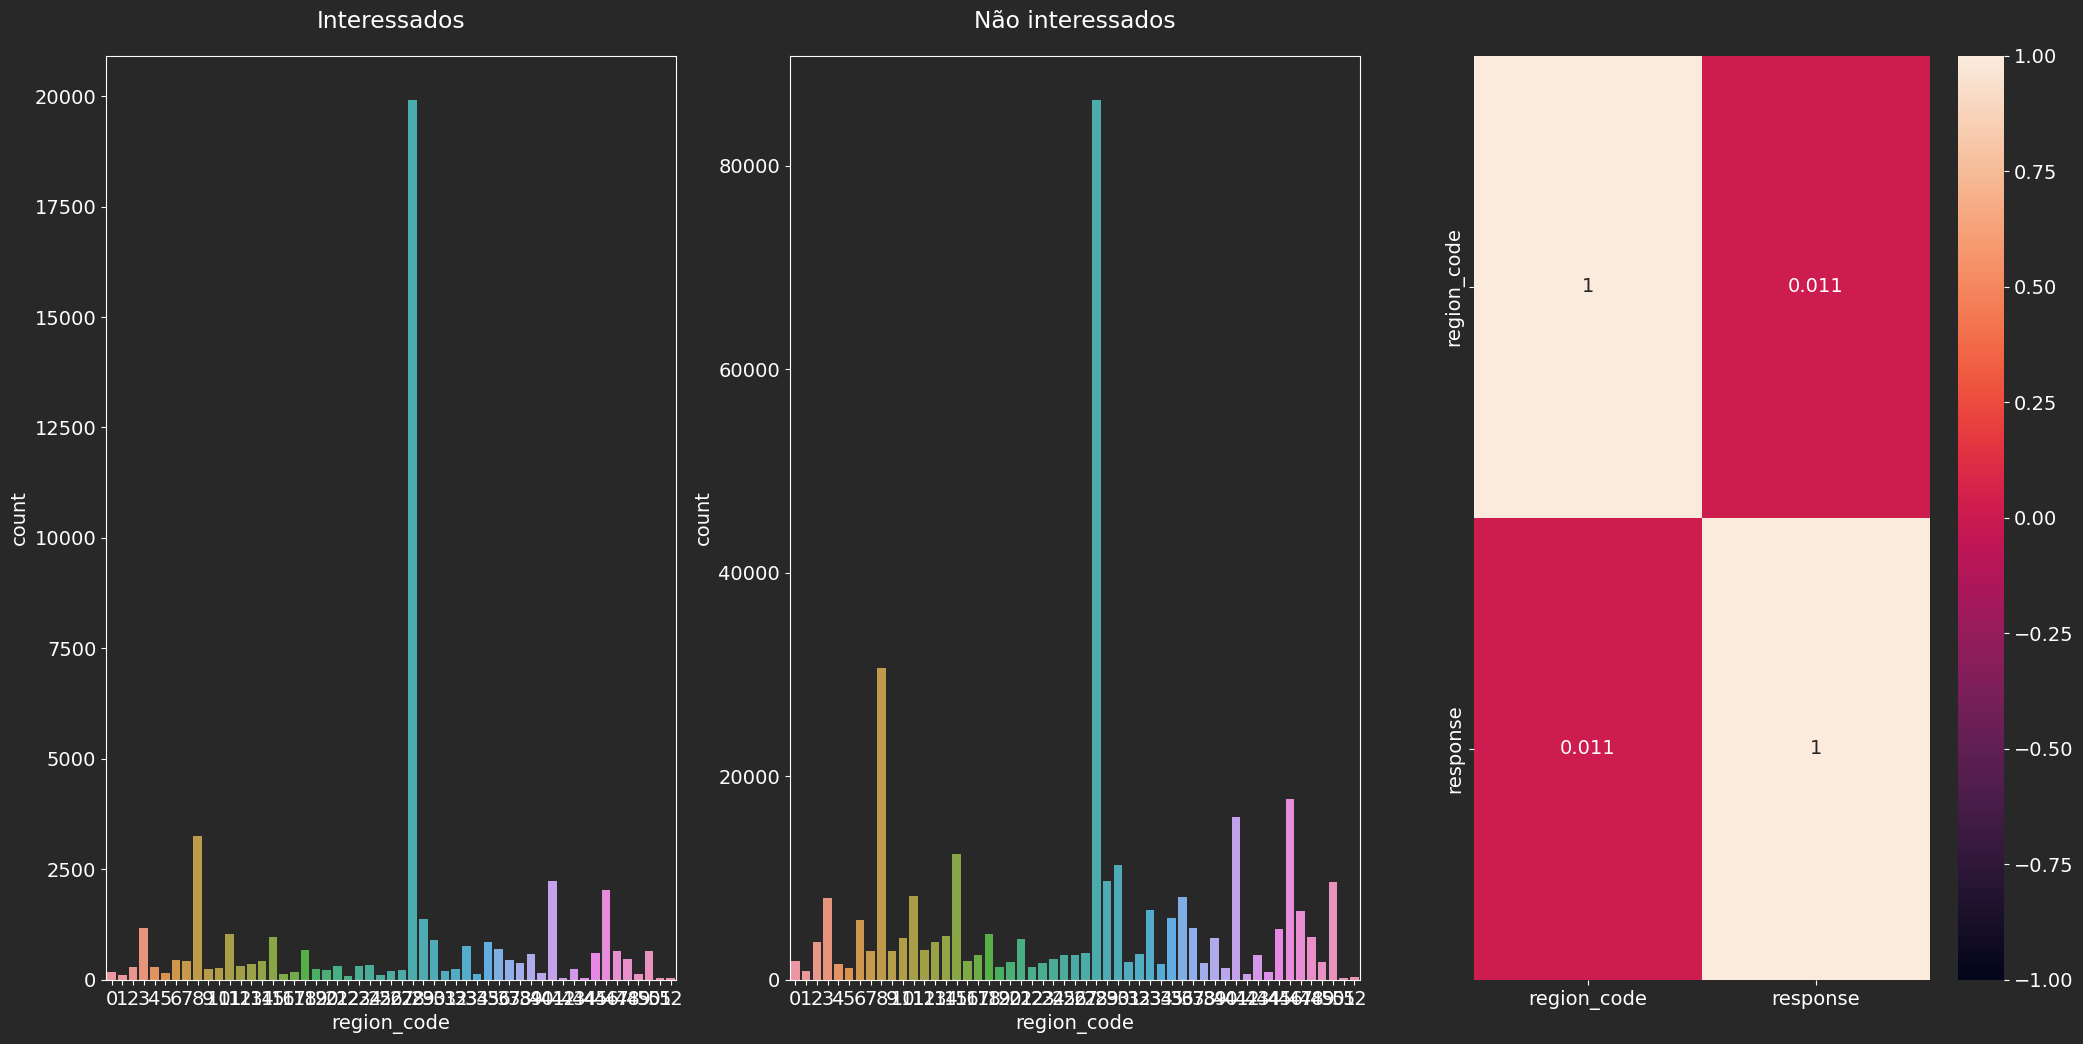

In [44]:
aux_channel_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_channel_1, x=aux_channel_1['region_code'])
plt.title('Interessados', pad=20)


aux_channel_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_channel_0, x=aux_channel_0['region_code'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
region_code_corr = df4[['region_code', 'response']].copy()
sns.heatmap(region_code_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.011: Very weak positive correlation.

# channel = aux_channel_1.loc[:,['region_code', 'id']].groupby(['region_code']).count().sort_values('id', ascending=False).reset_index()
# channel.head(10)

### **H5.** Clientes com o veículo já assegurado não possuem interesse no seguro.
**True** - Clientes com o veículo já assegurado não possuem interesse no seguro.

<Axes: >

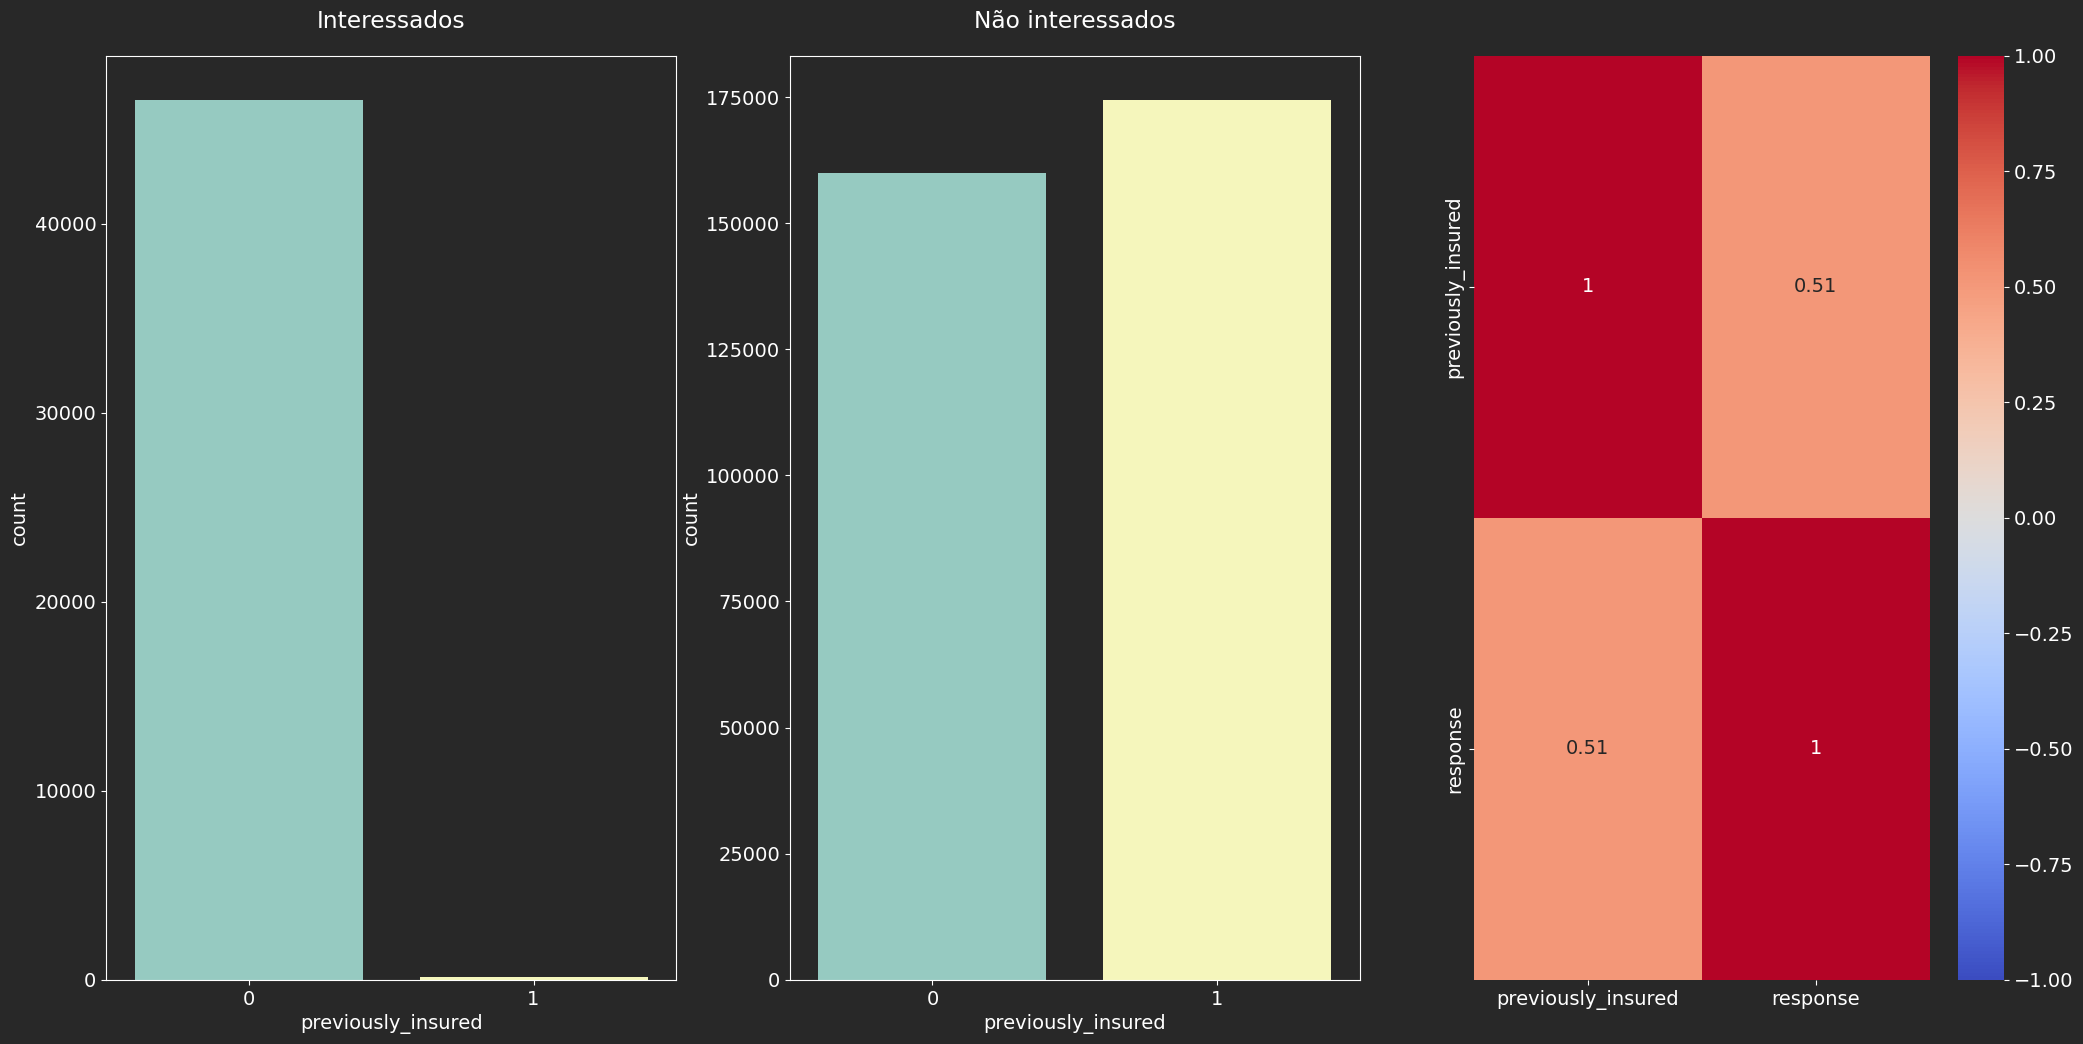

In [28]:
aux_prev_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_prev_1, x=aux_prev_1['previously_insured'])
plt.title('Interessados', pad=20)


aux_prev_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_prev_0, x=aux_prev_0['previously_insured'])
plt.title('Não interessados', pad=20)


previously_insured_corr = df4[['previously_insured', 'response']].copy()
plt.subplot(1, 3, 3)
phi_matrix = phik_matrix(previously_insured_corr, interval_cols=['response'])
sns.heatmap(data = phi_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Correlation found 0.51: Weak positive correlation.

### **H6.** Veículos mais novos possuem mais interesse no seguro.
**False** - Veículos entre 1 e 2 anos possuem mais interesse no seguro.


<Axes: >

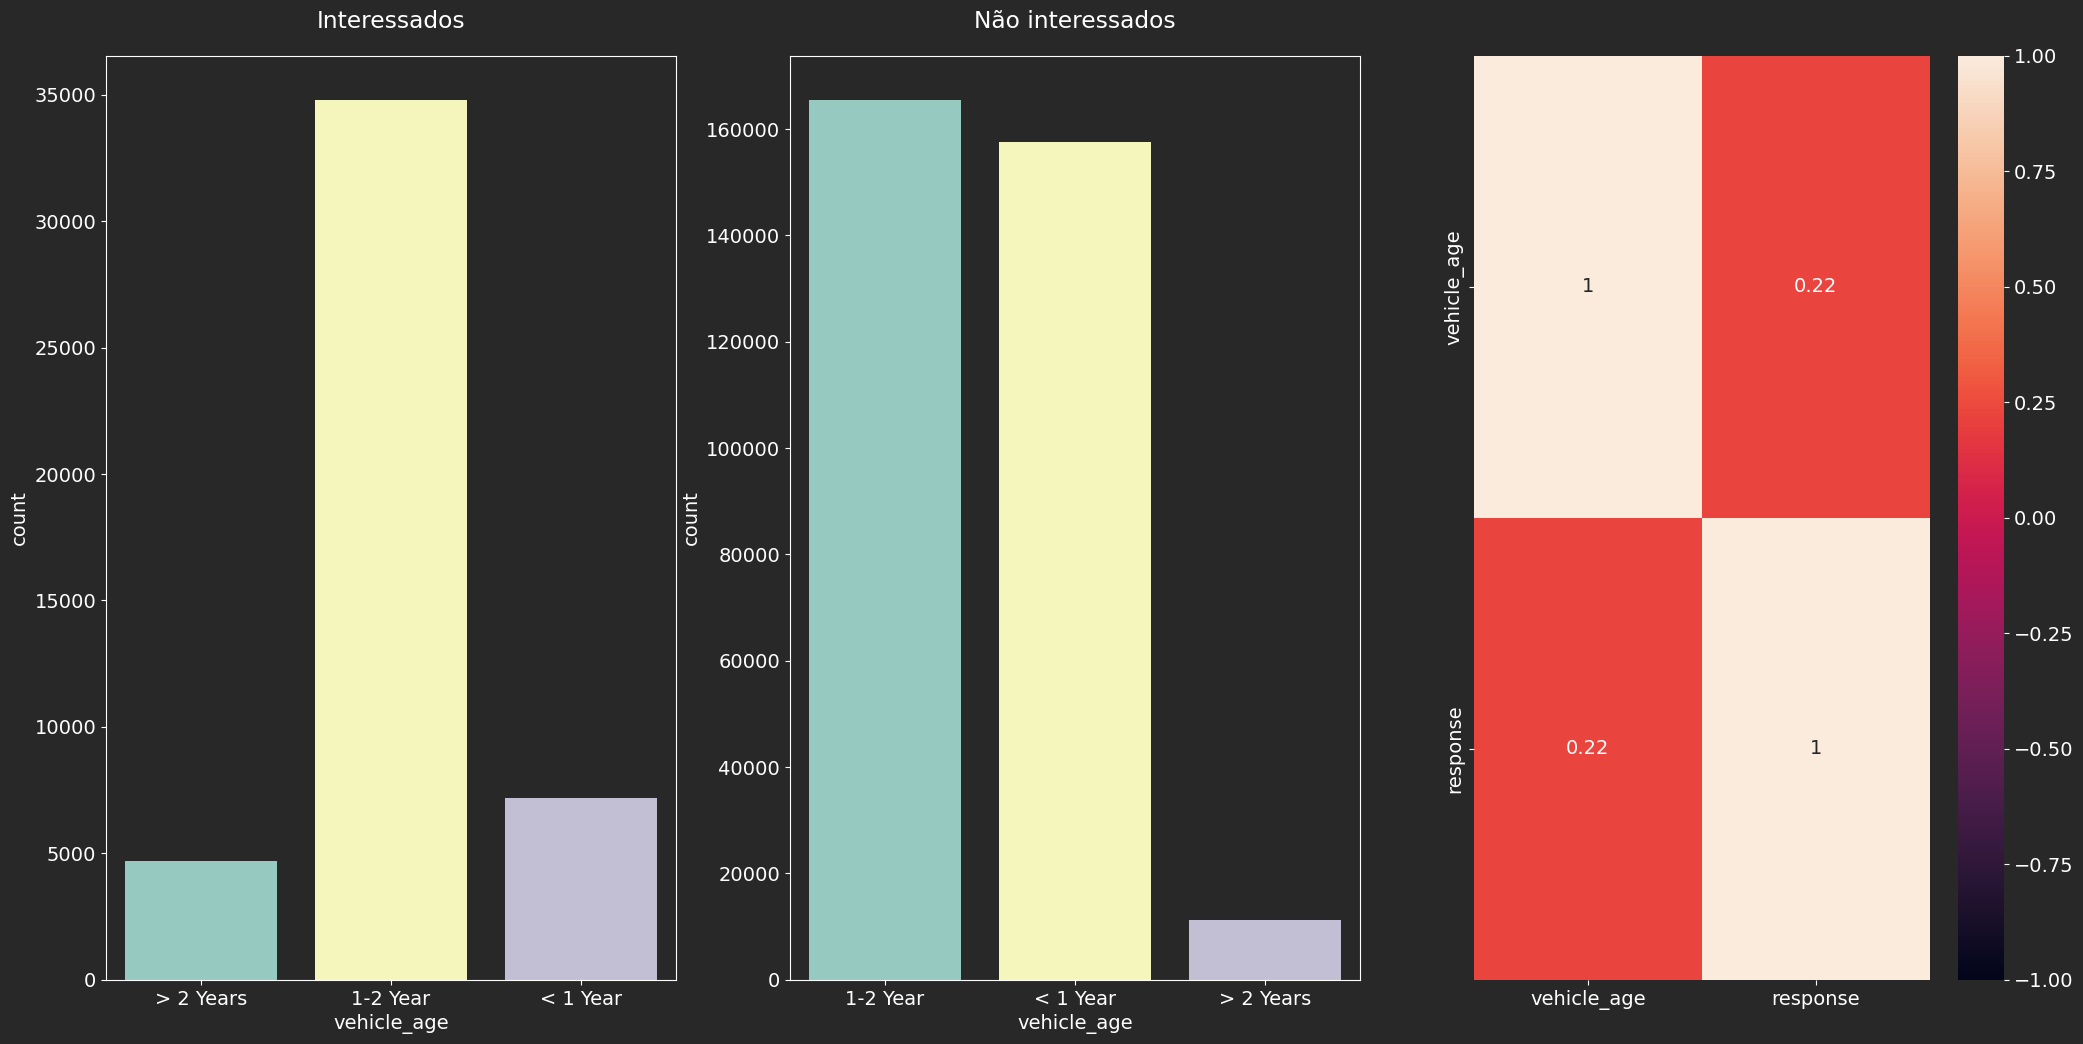

In [45]:
aux_vehicle_age_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_vehicle_age_1, x=aux_vehicle_age_1['vehicle_age'])
plt.title('Interessados', pad=20)


aux_vehicle_age_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_vehicle_age_0, x=aux_vehicle_age_0['vehicle_age'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
vehicle_age_corr = df4[['vehicle_age', 'response']].copy()
vehicle_age_corr['vehicle_age'] = vehicle_age_corr['vehicle_age'].apply(lambda x: 0 if x == '< 1 Year' else 1 if x == '1-2 Year' else 2)
sns.heatmap(vehicle_age_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.22: Very weak positive correlation.

### **H7.** Veículos já danificados possuem menos interesse no seguro.
**False** - Veículos já danificados possuem MAIS interesse no seguro.

<Axes: >

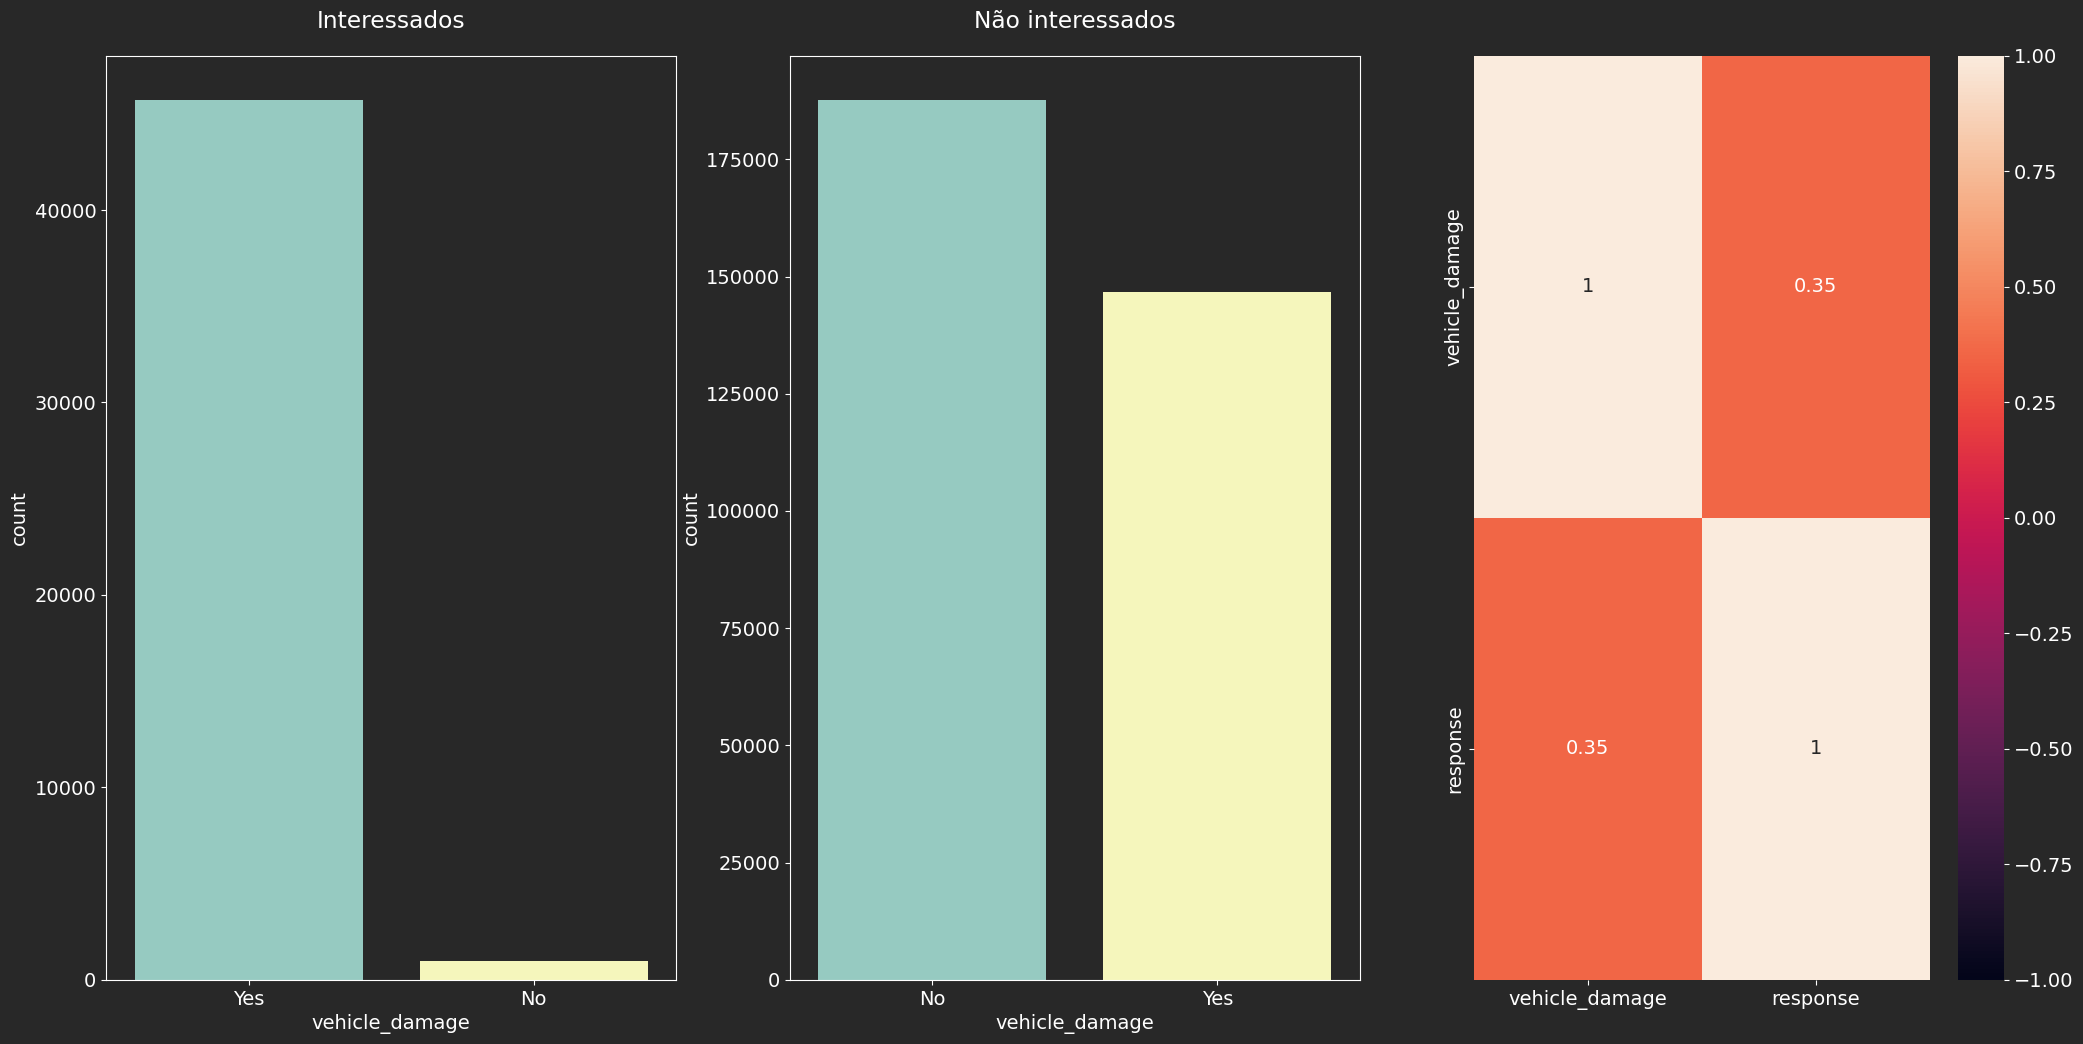

In [46]:
aux_vehicle_damage_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_vehicle_damage_1, x=aux_vehicle_damage_1['vehicle_damage'])
plt.title('Interessados', pad=20)


aux_vehicle_damage_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_vehicle_damage_0, x=aux_vehicle_damage_0['vehicle_damage'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
vehicle_damage_corr = df4[['vehicle_damage', 'response']].copy()
vehicle_damage_corr['vehicle_damage'] = vehicle_damage_corr['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)
sns.heatmap(vehicle_damage_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.35: Weak positive correlation.

### **H8.** Valores menores de seguro interessam mais os clientes.
**False** - Valores até 5000 possuem muitos clientes interessados mas também temos um grande interesse entre 25000 a 40000.

<Axes: >

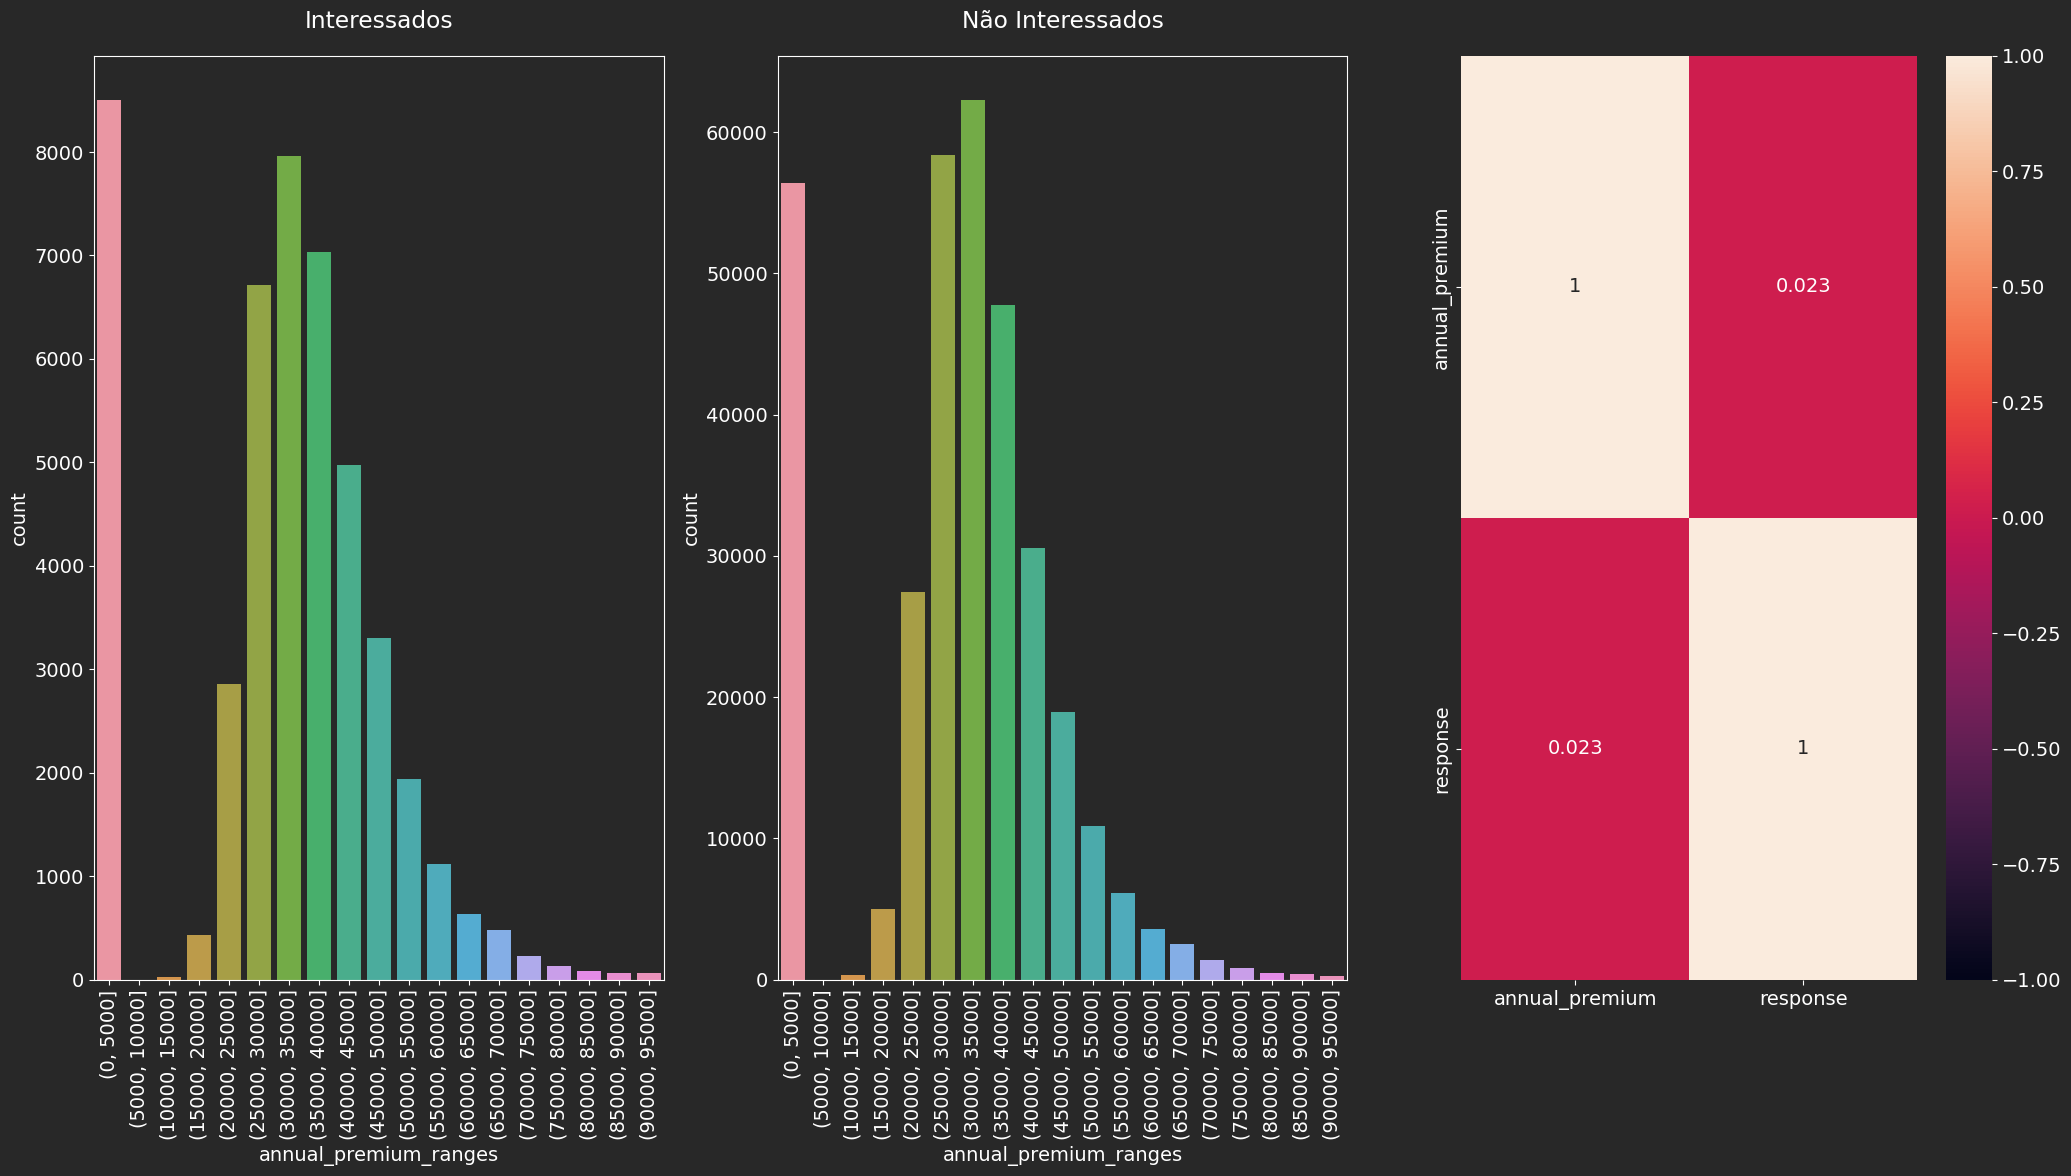

In [47]:
# Creating ranges
aux1 = df4[df4['response'] == 1].copy()
bins = list(np.arange(0, 100000, 5000))
aux1['annual_premium_ranges'] = pd.cut(aux1['annual_premium'], bins = bins)

aux0 = df4[df4['response'] == 0].copy()
bins = list(np.arange(0, 100000, 5000))
aux0['annual_premium_ranges'] = pd.cut(aux0['annual_premium'], bins = bins)


# plt.subplots_adjust(hspace=0.5)

plt.subplot(1, 3, 1)
sns.countplot(data=aux1, x=aux1['annual_premium_ranges'])
plt.xticks(rotation=90);
plt.title('Interessados', pad=20)

plt.subplot(1, 3, 2)
sns.countplot(data=aux0, x=aux0['annual_premium_ranges'])
plt.xticks(rotation=90);
plt.title('Não Interessados', pad=20)

# Correlation
plt.subplot(1, 3, 3)
anual_premium_corr = df4[['annual_premium', 'response']]
sns.heatmap(anual_premium_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found 0.023: Very weak positive correlation.


### **H9.** Os canais de vendas 122 e 160 possuem mais retorno positivo para o seguro.
**False** - Os canais de venda 26 e 124 possuem mais retorno positivo para o seguro.

<Axes: >

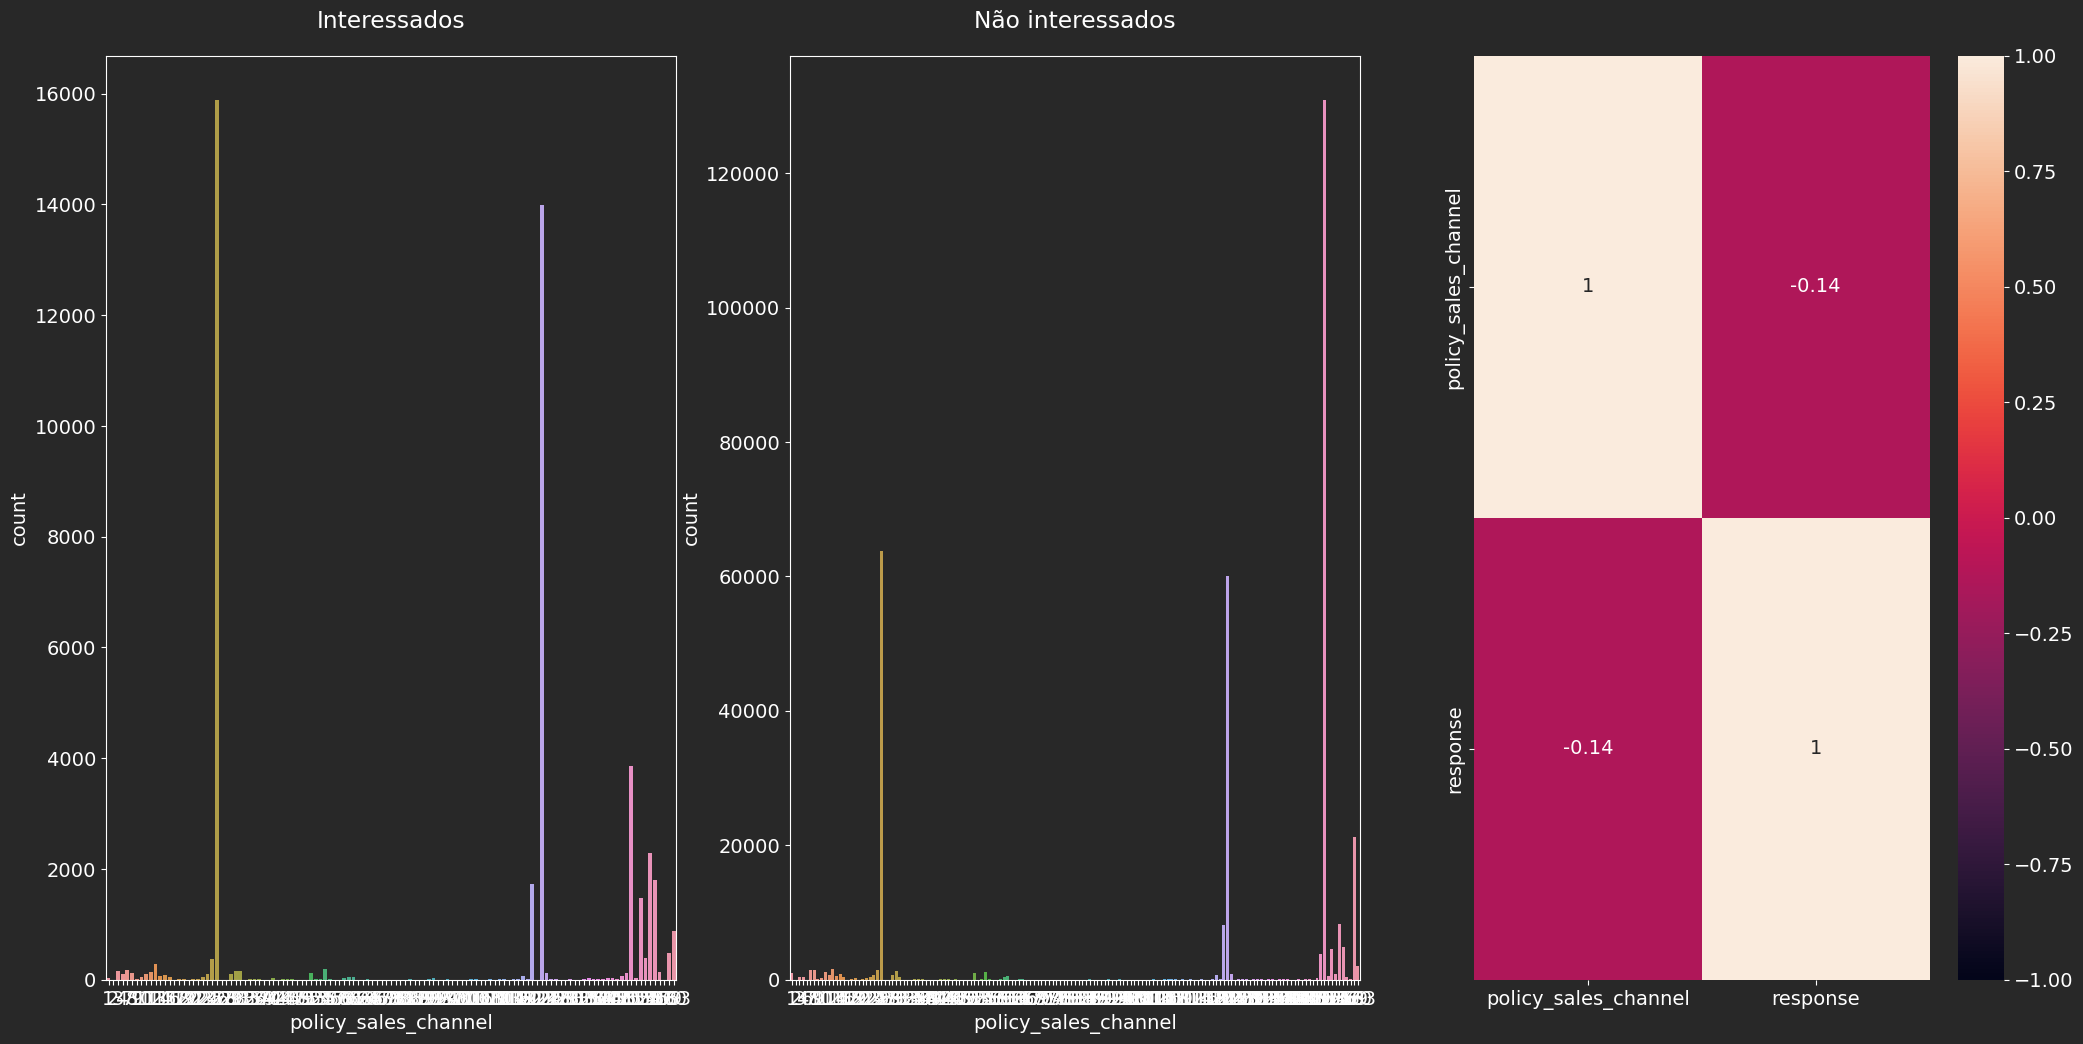

In [48]:
aux_channel_1 = df4[df4['response'] == 1]
plt.subplot(1, 3, 1)
sns.countplot(data=aux_channel_1, x=aux_channel_1['policy_sales_channel'])
plt.title('Interessados', pad=20)


aux_channel_0 = df4[df4['response'] == 0]
plt.subplot(1, 3, 2)
sns.countplot(data=aux_channel_0, x=aux_channel_0['policy_sales_channel'])
plt.title('Não interessados', pad=20)


plt.subplot(1, 3, 3)
policy_sales_channel_corr = df4[['policy_sales_channel', 'response']].copy()
sns.heatmap(policy_sales_channel_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found -0.14: Very weak negative correlation.

# channel = aux_channel_1.loc[:,['policy_sales_channel', 'id']].groupby(['policy_sales_channel']).count().sort_values('id', ascending=False).reset_index()
# channel.head(10)

### **H10.** Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.
**True** - Clientes a mais tempo assegurados possuem mais interesse no seguro de carro.

<Axes: >

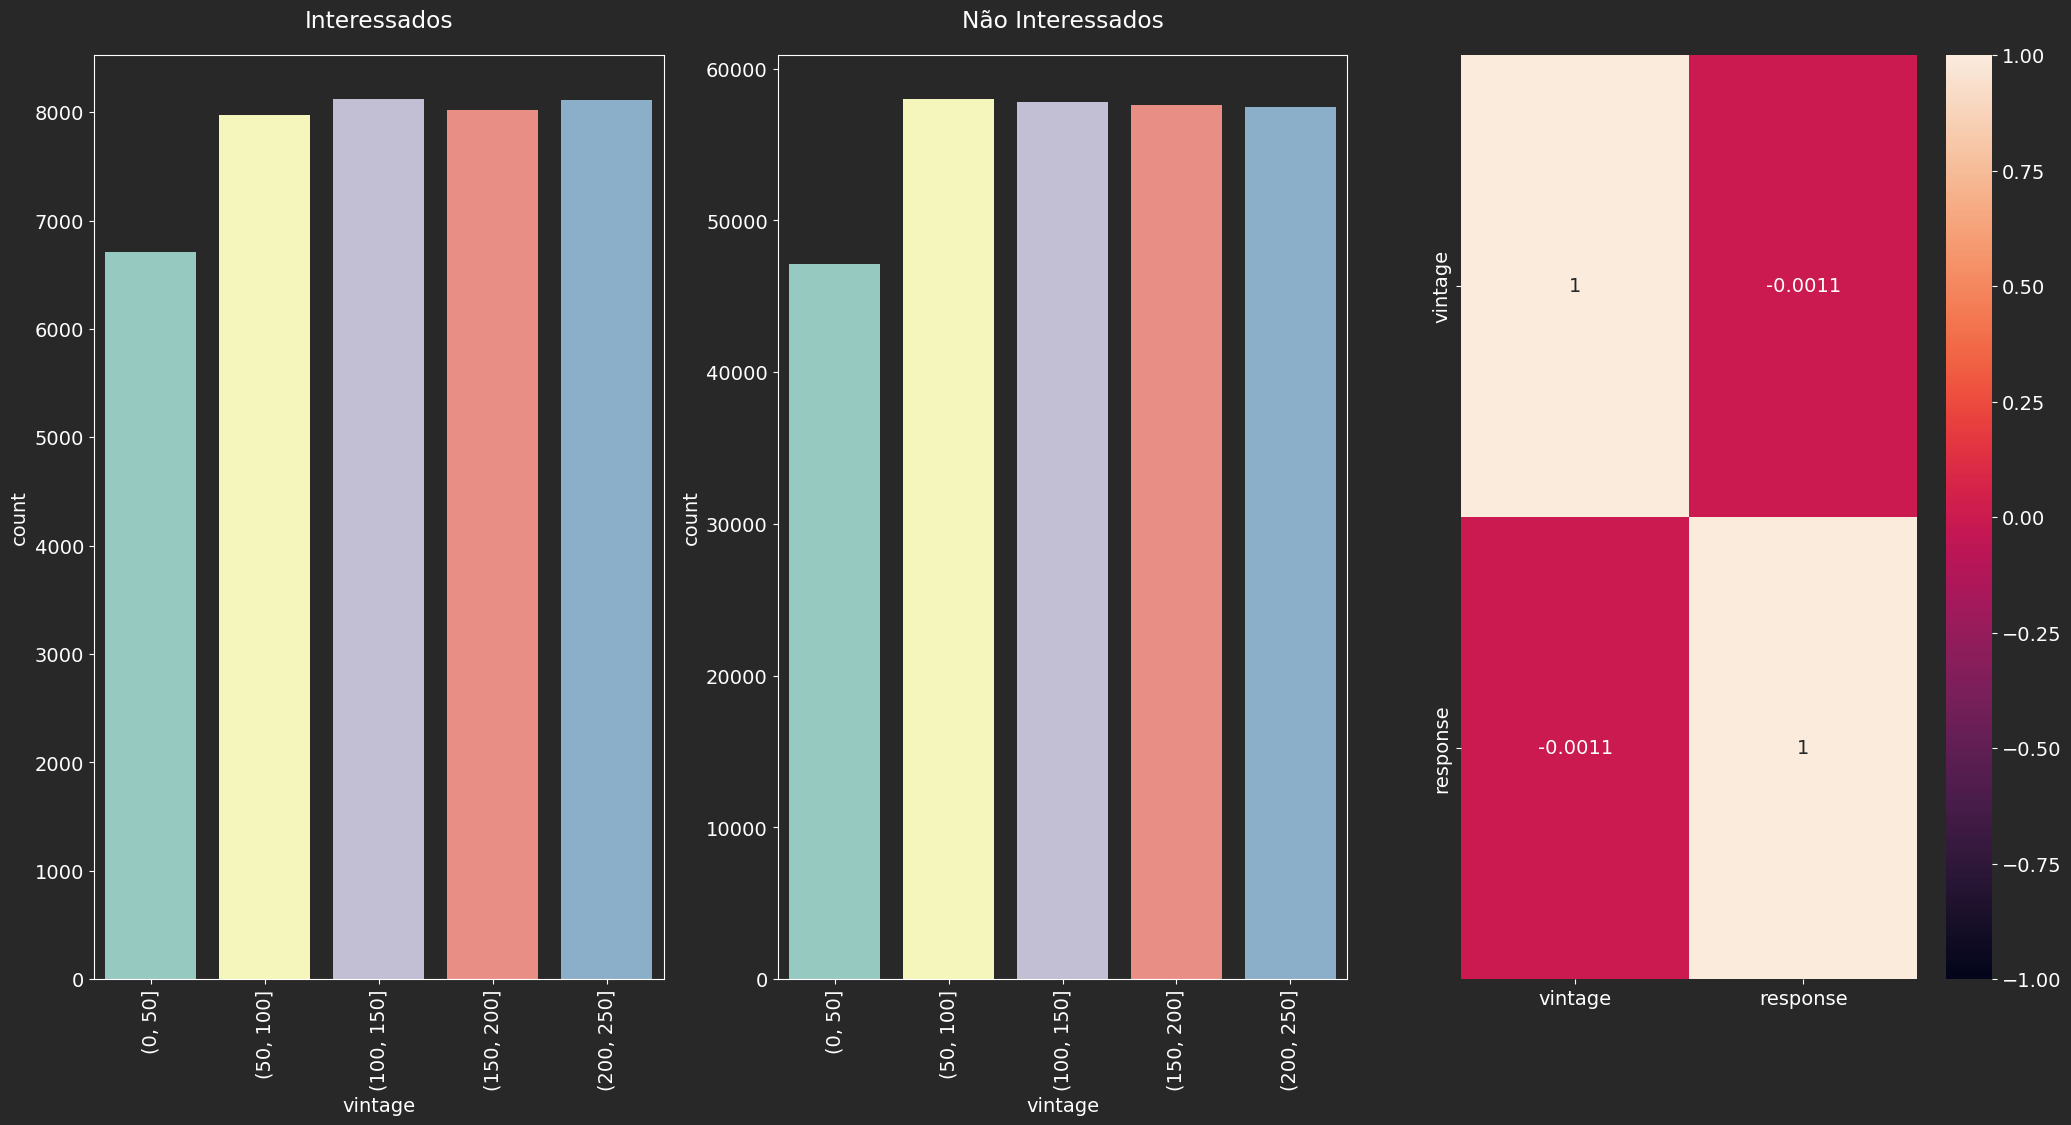

In [49]:
# Creating ranges
aux1 = df4[df4['response'] == 1].copy()
bins = list(np.arange(0, 300, 50))
aux1['vintage'] = pd.cut(aux1['vintage'], bins = bins)

aux0 = df4[df4['response'] == 0].copy()
bins = list(np.arange(0, 300, 50))
aux0['vintage'] = pd.cut(aux0['vintage'], bins = bins)


# plt.subplots_adjust(hspace=0.5)

plt.subplot(1, 3, 1)
sns.countplot(data=aux1, x=aux1['vintage'])
plt.xticks(rotation=90);
plt.title('Interessados', pad=20)

plt.subplot(1, 3, 2)
sns.countplot(data=aux0, x=aux0['vintage'])
plt.xticks(rotation=90);
plt.title('Não Interessados', pad=20)

# Correlation
plt.subplot(1, 3, 3)
vintage_corr = df4[['vintage', 'response']]
sns.heatmap(vintage_corr.corr(method='pearson'), annot=True, vmin=-1, vmax=1)

# Correlation found -0.0011: Very weak negative correlation.

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

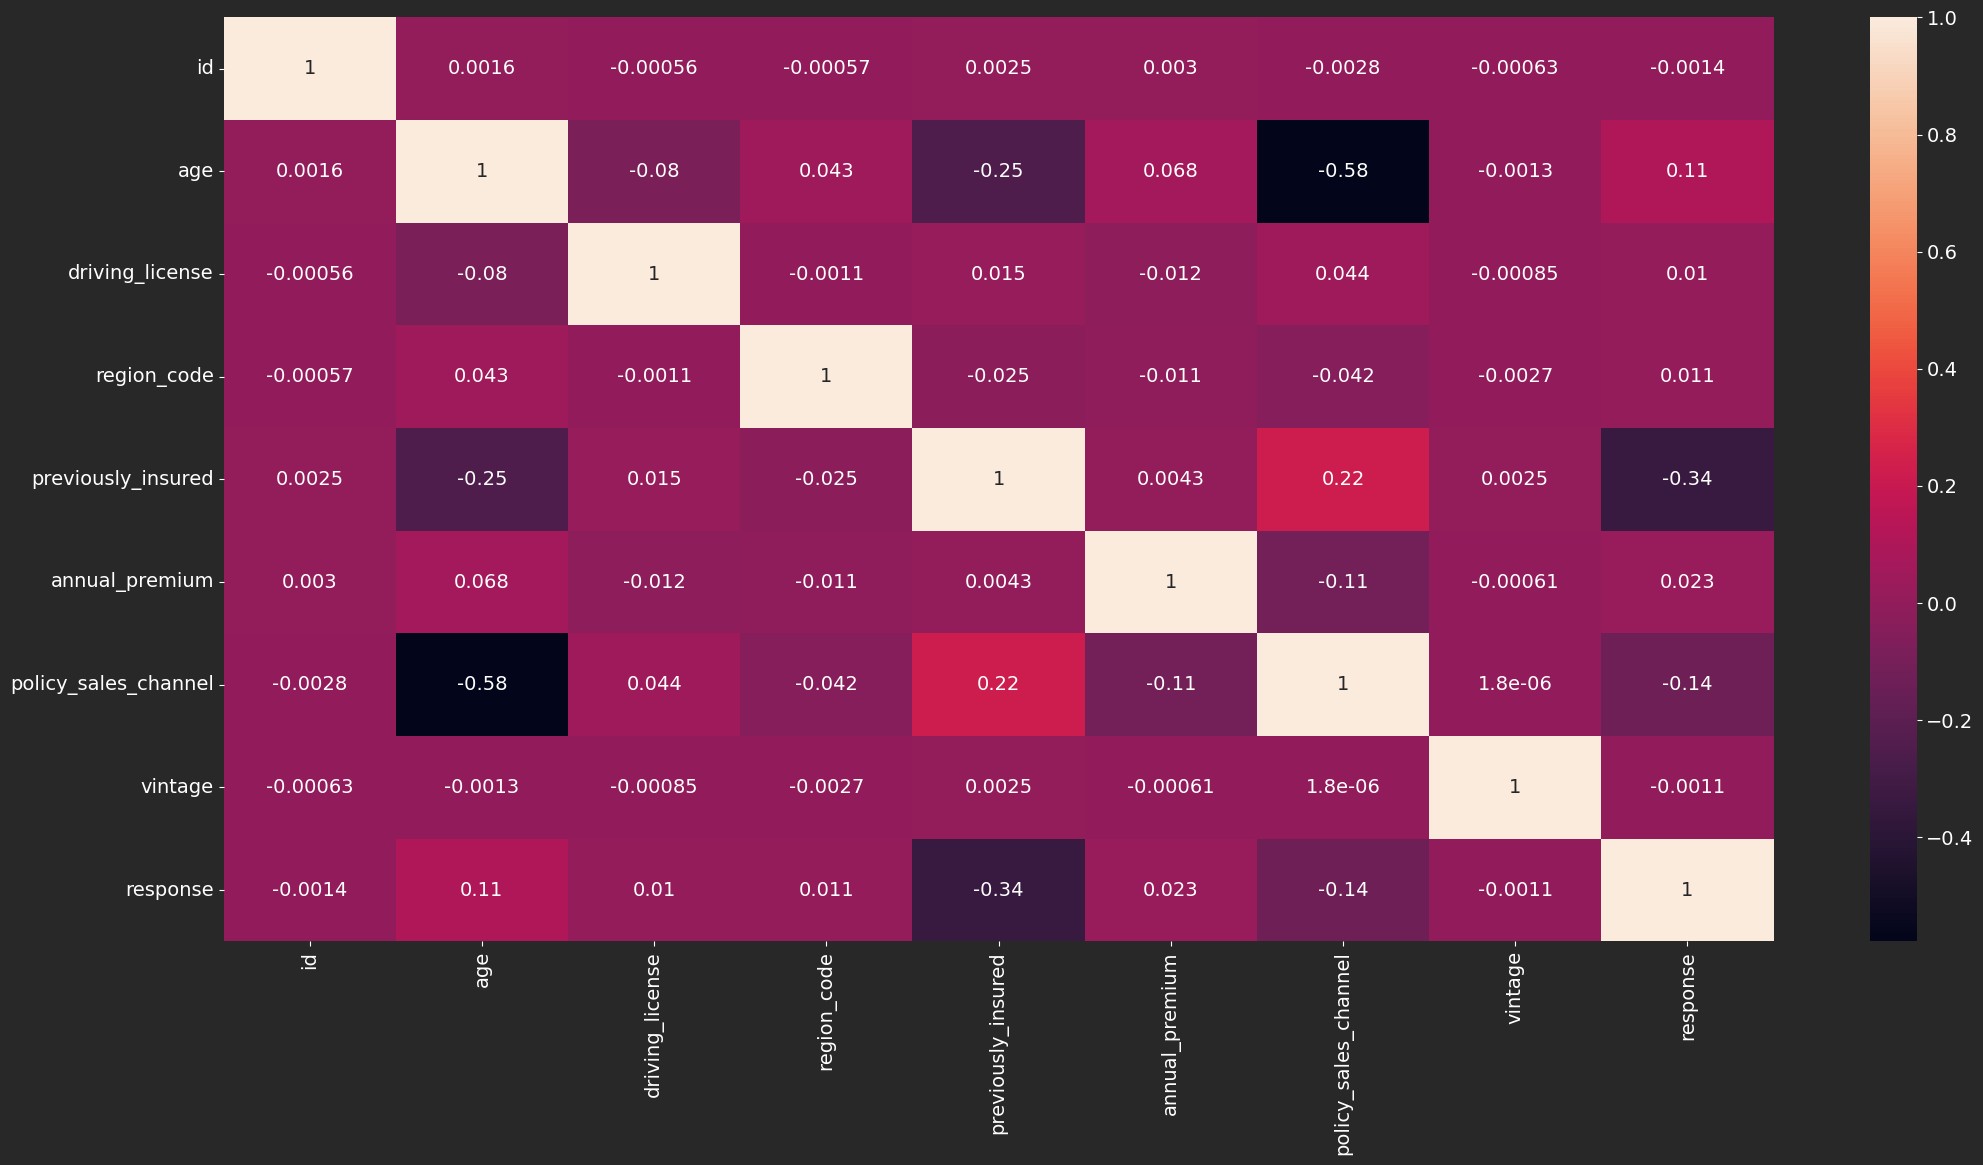

In [38]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [52]:
a = df4.select_dtypes(include='object')
a

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
381104,Male,1-2 Year,No
381105,Male,< 1 Year,No
381106,Male,< 1 Year,No
381107,Female,> 2 Years,Yes


In [60]:
# Calculate Cramer V

a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

d = pd.DataFrame({ 'gender': [a1, a2, a3],
              'vehicle_age': [a4, a5, a6],
              'vehicle_damage': [a7, a8, a9], })


# Final dataset
# Passa todas as colunas como index da tabela
d = d.set_index(d.columns)
d

,gender,vehicle_age,vehicle_damage
gender,0.999996,0.166786,0.091601
vehicle_age,0.166786,1.000003,0.396893
vehicle_damage,0.091601,0.396893,0.999996


<Axes: >

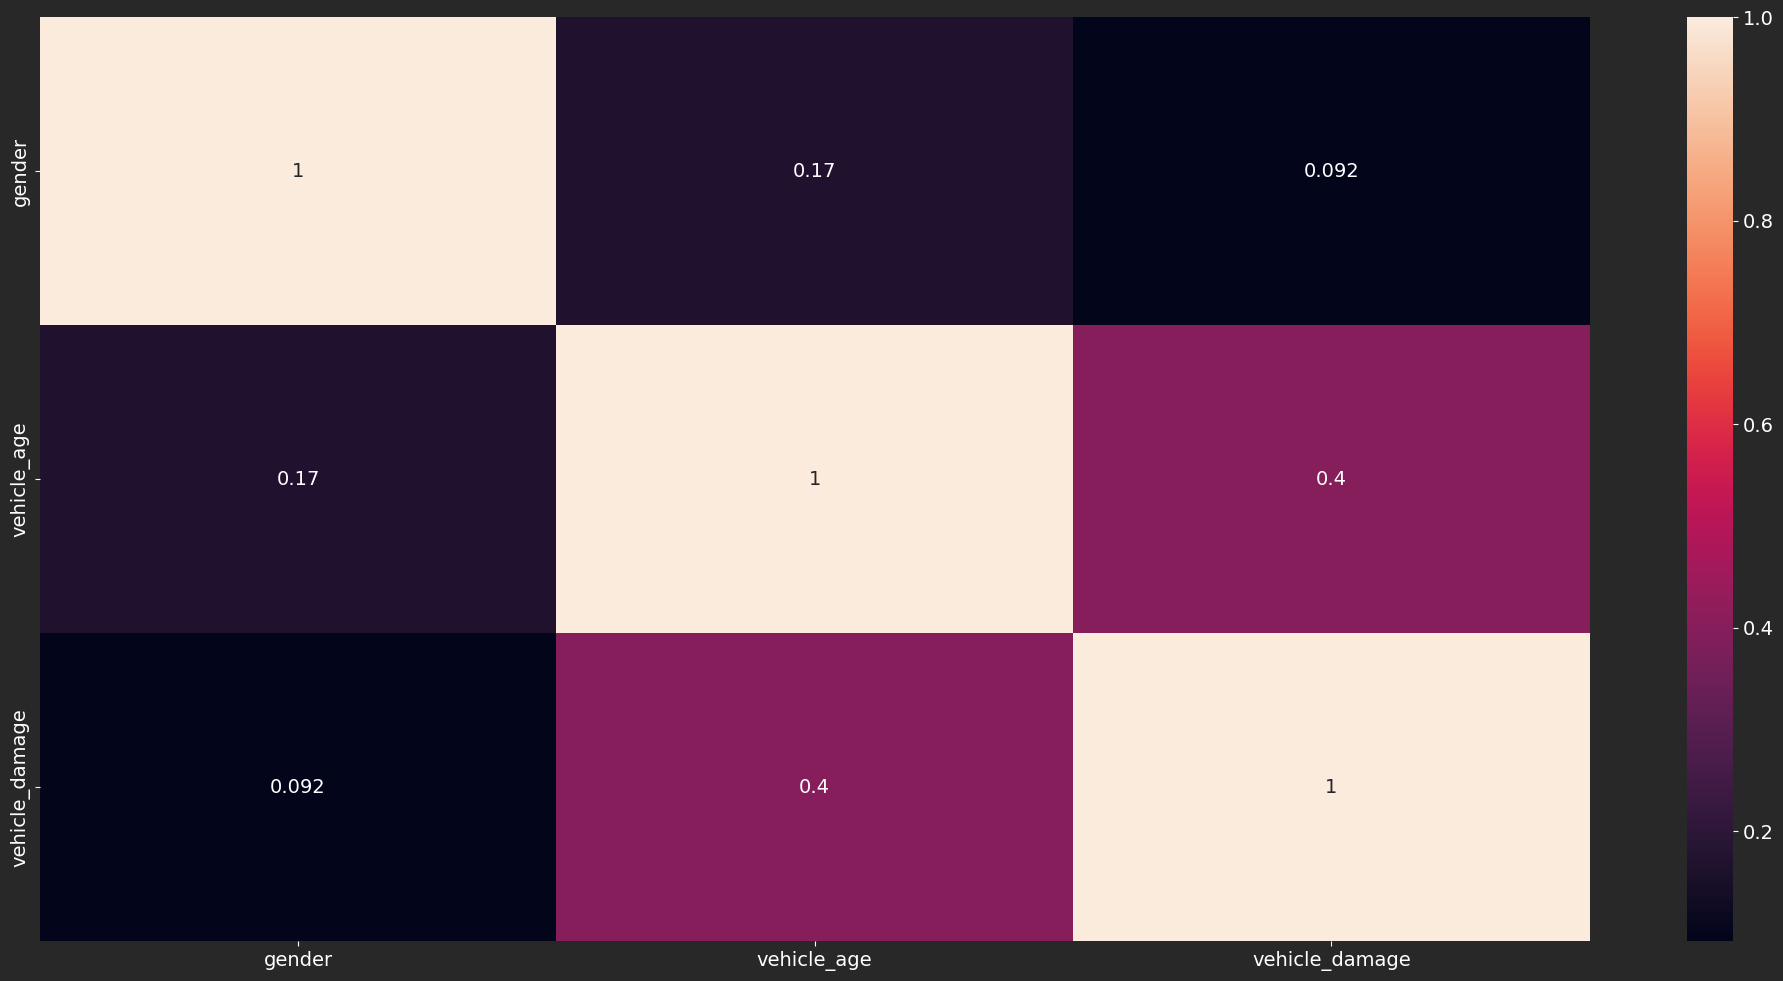

In [61]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [62]:
df5 = df4.copy()

In [63]:
# no treino fit_transform e no teste só transform
# fazer um rs ou mms para cada coluna.

# evitar o label encoder

## 5.1 Split train and test

In [ ]:
rs_age = RobustScaler()

df5['age'] = rs_age.fit_transform( df5[['age']].values)
rs_age.transform( df5[['age']].values)

evitar o label encoder


array([[ 0.33333333],
       [ 1.66666667],
       [ 0.45833333],
       ...,
       [-0.625     ],
       [ 1.33333333],
       [ 0.41666667]])

In [ ]:
rs_age = RobustScaler()

df5['age'] = rs_age.fit_transform( df5[['age']].values)

df4['age'] = rs_age.transform( df4[['age']].values)

In [ ]:
df5['age']

0         0.333333
1         1.666667
2         0.458333
3        -0.625000
4        -0.291667
            ...   
381104    1.583333
381105   -0.250000
381106   -0.625000
381107    1.333333
381108    0.416667
Name: age, Length: 381109, dtype: float64

## 5.2 Normalização

In [ ]:
# Como não foram encontradas vars com distribuição normal no tópico 4.1.2, então não será necessário normalizar. 
# Não forçarei normalização.

## 5.3 Rescaling

In [ ]:
r = df5.select_dtypes(include=['int', 'float'])
r.columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [ ]:
r.head()

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
0,1,44,1,28,0,40454.0,26,217,1
1,2,76,1,3,0,33536.0,26,183,0
2,3,47,1,28,0,38294.0,26,27,1
3,4,21,1,11,1,28619.0,152,203,0
4,5,29,1,41,1,27496.0,152,39,0


r.head()